# Read and analyze case 6126 E08 (Ajia) - 2   [ K-means clustering ]

**BMED320: Methods in biomedical research (IMC-ML)  / 2020-11-23**<br>


Using data from Damond et al. A Map of Human Type 1 Diabetes Progression by Imaging Mass Cytometry. Celll Metabolism 2019;29(3):755-768.e5<br>
See: https://github.com/arvidl/BMED320-imaging-mass-cytometry-ml/blob/master/notebooks/imc-case-damond-2019/README.md


## Progression by Imaging Mass Cytometry

Published: 09-04-2020  **Version 2**  **DOI**:10.17632/cydmwsfztj.2  [[link](https://data.mendeley.com/datasets/cydmwsfztj/2)]<br>
Contributor: Nicolas Damond

### Description
Data related to the publication: "A Map of Human Type 1 Diabetes Progression by Imaging Mass Cytometry".

Damond N, Engler S, Zanotelli VRT, Schapiro D, Wasserfall CH, Kusmartseva I, Nick HS, Thorel F, Herrera PL, Atkinson MA and Bodenmiller B. Cell Metab. 2019 Mar 5;29(3):755-768.e5. https://doi.org/10.1016/j.cmet.2018.11.014

We used imaging mass cytometry to simultaneously image 37 biomarkers with single-cell and spatial resolution in pancreas sections from 12 human donors at different stages of type 1 diabetes.
```shell
CODE:
- Python script for coordinate transformation
- Functions for custom histoCAT neighborhood analysis

DATA:
- Single-cell data
- Islet-level data
- Cell type information
- Cell relationships (cell-cell neighborhoods and cell-islet relationships)
- Donors and image metadata.
- Subset containing the data for 100 images from 3 donors

IMAGES:
- Image stacks (37 channels) for all donors (one .7z file per donor, numbers indicate nPOD case IDs)
- Cell masks
- Panel file with information related to antibodies and metal tags
- Metadata file linking donor information to images
- Metadata file linking image stack slices and panel information
- Subset containing 100 images from 3 donors
```


- Downloads --> cydmwsfztj-1 --> Data --> Images -->  Panel.csv (1 KB) / Metadata.csv (25 KB) / 6126.7z (360 MB)

- 6126.7z (360 MB) --> E08_a0_full.csv (222 B) / E08_a0_full.tiff (42 MB)

| **image**	 | **case**	| **slide**	 | **part**	| **group** |	**stage**  |
| :--------: | :------: | :--------: | :------: | :-------: | :---------:  |
|   E08	     | 6126	    | E	         | Tail	    |       1   | Non-diabetic |

**E08_a0_full.csv**: 
In113
In115
Pr141
Nd142
Nd143
Nd144
Nd145
Nd146
Sm147
Nd148
Sm149
Nd150
Sm152
Eu153
Sm154
Gd156
Gd158
Tb159
Gd160
Dy161
Dy162
Dy163
Dy164
Ho165
Er166
Er167
Er168
Tm169
Er170
Yb171
Yb172
Yb173
Yb174
Lu175
Yb176
Ir191
Ir193

### Import the libraries being used

In [1]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from skimage import io
from skimage import color
from skimage import morphology
from skimage.morphology import disk
from skimage.filters import median
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from scipy import ndimage
from skimage.filters import threshold_otsu
from skimage import img_as_ubyte
from skimage import img_as_float
from scipy.ndimage import gaussian_filter
from skimage.morphology import reconstruction
import nibabel as nib
import os
home = os.path.expanduser('~')  # To make path to local home directory
import tifffile as tiff
from pycaret.clustering import *

### Define the data being used

In [2]:
fn_tiff = './data/E08_a0_full.tiff'
fn_csv = './data/E08_a0_full.csv'
fn_panel = './data/table1_IMC_panel_37x4.csv'

# For direct inclusion of figures and tables in the Overleaf on Linux / MacOS and NOT Windows ('nt')
# i.e. LaTeX document (Overleaf is synced with Dropbox on MacOS/Linux)
if os.name == 'nt':
    fn_fig_base = '%s/tmp' % home
    fn_tab_base = '%s/tmp' % home
else:    
    fn_fig_base = '%s/Dropbox/Apps/Overleaf/Imaging_Mass_Cytometry_and_Machine_Learning_BMED320_project2020/Figs' % (home)
    fn_tab_base = '%s/Dropbox/Apps/Overleaf/Imaging_Mass_Cytometry_and_Machine_Learning_BMED320_project2020' % (home)

### Read the IMC imagefile and print characteristics

In [3]:
im = io.imread(fn_tiff)
print(type(im))
print(im.shape)

<class 'numpy.ndarray'>
(37, 530, 567)


### Get number of channels in the recording

In [4]:
n_chn = im.shape[0]
n_chn

37

### Read the Panel file and channel numbering into a Pandas dataframe

!! In the original data, there was an nconsistency in Panel vs. IMC channel list (175Yb vs. Lu175) !!

In [5]:
fn = './data/E08_a0_panel_data_and_channel_numbering.csv'
df_p = pd.read_csv(fn)
print(df_p.shape)
df_p

(37, 5)


Short Name                                            Antigen  \
0         INS                                            Insulin   
1         PIN                                         Proinsulin   
2         GCG                                           Glucagon   
3         SST                                       Somatostatin   
4         PPY                             Pancreatic polypeptide   
5      NKX6-1                           Homeobox protein Nkx-6.1   
6        PDX1                 Pancreatic and duodenal homeobox 1   
7        IAPP                                             Amylin   
8       PCSK2                            Proprotein convertase 2   
9         SYP                                      Synaptophysin   
10       CD99                                               CD99   
11     SLC2A1                              Glucose transporter 1   
12      PTPRN  Receptor-type tyrosine-protein phosphatase-like N   
13      AMY2A                                 Pancreatic amylase   
14      KRT19                                     Cytokeratin 19   
15       CD44                                               CD44   
16       CD45                                               CD45   
17     CD45RA                                             CD45RA   
18       CD3e                                               CD3ɛ   
19        CD4                                                CD4   
20       CD8a                                               CD8a   
21       CD20                                               CD20   
22       CD68                                               CD68   
23        MPO                                    Myeloperoxidase   
24      FOXP3                                    Forkhead box P3   
25       CD38                                               CD38   
26        CDH                                      E-/P-cadherin   
27       CD31                                               CD31   
28        SMA                                Smooth muscle actin   
29      KI-67                                              Ki-67   
30        pH3                                 Phospho-histone H3   
31       pRB1                             Phospho-retinoblastoma   
32     cPARP1  Cleaved caspase 3 + cleaved poly (ADP-ribose) ...   
33        CA9                              Carbonic anhydrase IX   
34         H3                                         Histone H3   
35      Ir191                                (DNA intercalators)   
36      Ir193                                (DNA intercalators)   

        Main Target Cells Metal Tag  Chn  
0                       β     141Pr    3  
1                       β     154Sm   15  
2                       α     156Gd   16  
3                       δ     159Tb   18  
4                       γ     153Eu   14  
5                       β     169Tm   28  
6              β δ ductal     158Gd   17  
7                       β     167Er   26  
8                       α     144Nd    6  
9               Endocrine     160Gd   19  
10              Endocrine     145Nd    7  
11              Endocrine     148Nd   10  
12              Endocrine     174Yb   33  
13                 Acinar     150Nd   12  
14                 Ductal     161Dy   20  
15               Exocrine     143Nd    5  
16                 Immune     162Dy   21  
17                 Immune     164Dy   23  
18                      T     152Sm   13  
19               Helper T     171Yb   30  
20            Cytotoxic T     165Ho   24  
21                      B     149Sm   11  
22  Monocytes macrophages     146Nd    8  
23            Neutrophils     147Sm    9  
24           Regulatory T     163Dy   22  
25                 Immune     142Nd    4  
26             Epithelial     173Yb   32  
27            Endothelial     172Yb   31  
28                Stromal     115In    2  
29          Proliferating     168Er   27  
30          Proliferating     170Er   29  
31                Cycling     175Yb   34  

In [6]:
df_p_sort_chn = df_p.sort_values('Chn')
df_p_sort_chn

Short Name                                            Antigen  \
34         H3                                         Histone H3   
28        SMA                                Smooth muscle actin   
0         INS                                            Insulin   
25       CD38                                               CD38   
15       CD44                                               CD44   
8       PCSK2                            Proprotein convertase 2   
10       CD99                                               CD99   
22       CD68                                               CD68   
23        MPO                                    Myeloperoxidase   
11     SLC2A1                              Glucose transporter 1   
21       CD20                                               CD20   
13      AMY2A                                 Pancreatic amylase   
18       CD3e                                               CD3ɛ   
4         PPY                             Pancreatic polypeptide   
1         PIN                                         Proinsulin   
2         GCG                                           Glucagon   
6        PDX1                 Pancreatic and duodenal homeobox 1   
3         SST                                       Somatostatin   
9         SYP                                      Synaptophysin   
14      KRT19                                     Cytokeratin 19   
16       CD45                                               CD45   
24      FOXP3                                    Forkhead box P3   
17     CD45RA                                             CD45RA   
20       CD8a                                               CD8a   
33        CA9                              Carbonic anhydrase IX   
7        IAPP                                             Amylin   
29      KI-67                                              Ki-67   
5      NKX6-1                           Homeobox protein Nkx-6.1   
30        pH3                                 Phospho-histone H3   
19        CD4                                                CD4   
27       CD31                                               CD31   
26        CDH                                      E-/P-cadherin   
12      PTPRN  Receptor-type tyrosine-protein phosphatase-like N   
31       pRB1                             Phospho-retinoblastoma   
32     cPARP1  Cleaved caspase 3 + cleaved poly (ADP-ribose) ...   
35      Ir191                                (DNA intercalators)   
36      Ir193                                (DNA intercalators)   

        Main Target Cells Metal Tag  Chn  
34                 Nuclei     113In    1  
28                Stromal     115In    2  
0                       β     141Pr    3  
25                 Immune     142Nd    4  
15               Exocrine     143Nd    5  
8                       α     144Nd    6  
10              Endocrine     145Nd    7  
22  Monocytes macrophages     146Nd    8  
23            Neutrophils     147Sm    9  
11              Endocrine     148Nd   10  
21                      B     149Sm   11  
13                 Acinar     150Nd   12  
18                      T     152Sm   13  
4                       γ     153Eu   14  
1                       β     154Sm   15  
2                       α     156Gd   16  
6              β δ ductal     158Gd   17  
3                       δ     159Tb   18  
9               Endocrine     160Gd   19  
14                 Ductal     161Dy   20  
16                 Immune     162Dy   21  
24           Regulatory T     163Dy   22  
17                 Immune     164Dy   23  
20            Cytotoxic T     165Ho   24  
33                Hypoxic     166Er   25  
7                       β     167Er   26  
29          Proliferating     168Er   27  
5                       β     169Tm   28  
30          Proliferating     170Er   29  
19               Helper T     171Yb   30  
27            Endothelial     172Yb   31  
26             Epithelial     173Yb   32  

### Plot the IMC dataset as a 7 x 6 grid of color-coded channels (and save Fig for the Overleaf document)

With histogram equalization for better visualization
https://stackoverflow.com/questions/28518684/histogram-equalization-of-grayscale-images-with-numpy

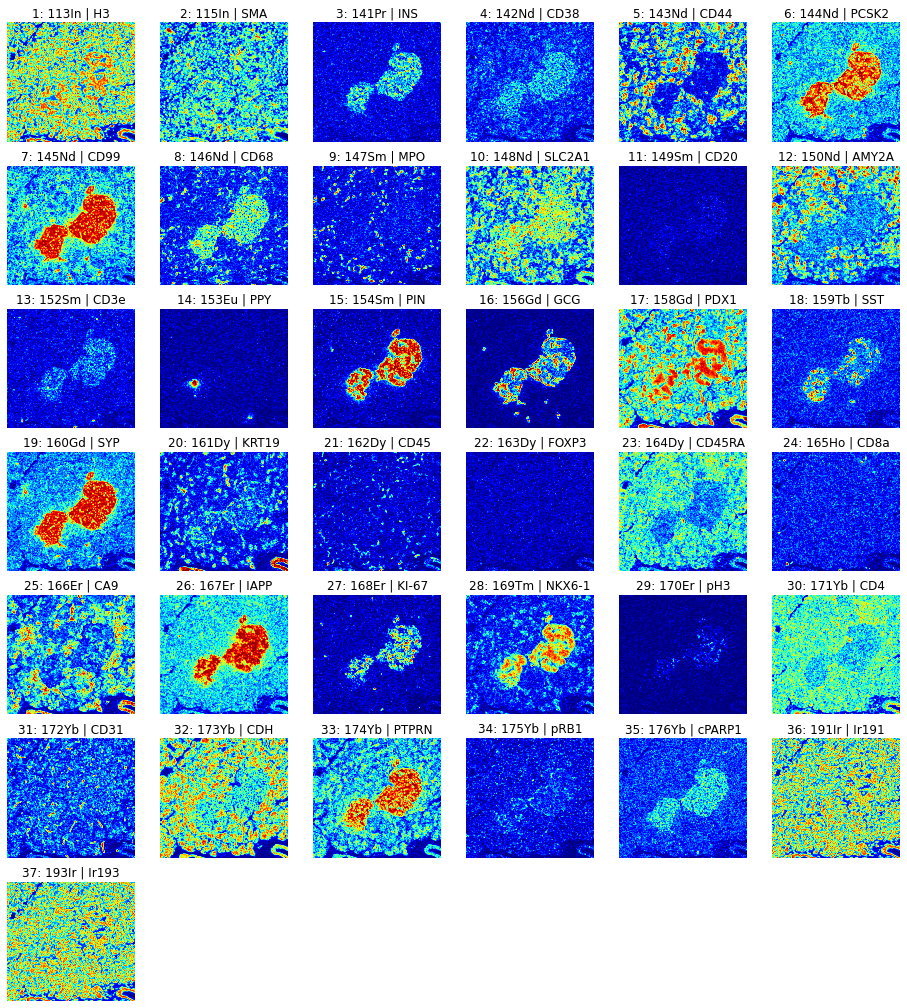

In [7]:
fig_fn = '%s/BMED320_experiments_case6126_E08_channel_eq_mosaic_jet.pdf' % fn_fig_base
fig, axes = plt.subplots(7, 6, figsize=(16, 18), sharex=False, sharey=False)
ax = axes.ravel()
for i, item in enumerate(range(n_chn)):
    chn = np.squeeze(im[i,:,:])
    chn_eq = np.sort(chn.ravel()).searchsorted(chn)  # a kind of histogram equalization
    ax[i].imshow(chn_eq, cmap='jet' )   # cmap='jet', 'gray'
    ax[i].set_title('%d: %s | %s' % ((i+1), df_p_sort_chn['Metal Tag'].iloc[i], df_p_sort_chn['Short Name'].iloc[i]))
    ax[i].axis('off')
chn_0 = np.zeros(chn.shape )   
for j in range(n_chn,7*6):
    ax[j].imshow(chn_0, cmap='gray_r') 
    ax[j].axis('off')
# plt.savefig(fig_fn, bbox_inches='tight')
plt.show()

In [8]:
im.shape

(37, 530, 567)

### Preparation of the multichannel IMC image for NIFTI format saving to disk - cf. notebook 1 

```python
def hist_eq(chn):
    return np.sort(chn.ravel()).searchsorted(chn)

imc_img = np.zeros(shape=(im.shape[2], im.shape[1], 1, im.shape[0]))
imc_img_eq = np.zeros(shape=(im.shape[2], im.shape[1], 1, im.shape[0]))
print(imc_img.shape)
for i in range(im.shape[0]):
    a = np.squeeze(im[i,:,:])
    b = np.squeeze(hist_eq(im[i,:,:]))
    imc_img[:,:,0,i] = a[::-1,::-1].T /a.max()
    imc_img_eq[:,:,0,i] = b[::-1,::-1].T /b.max()
    
imc_nii = nib.Nifti1Image(imc_img, affine=np.eye(4))
imc_nii_eq = nib.Nifti1Image(imc_img_eq, affine=np.eye(4))  # "histogram equalized channels" image

nib.save(imc_nii, './data/imc_%d_chns.nii.gz' % (im.shape[0]))
nib.save(imc_nii_eq, './data/imc_%d_chns_eq.nii.gz' % (im.shape[0]))
```

### Read neuroimaging NIFTI-formated multichannel IMC image 
**(for using neuroimaging display tools like Freesurfer's [FreeView](https://surfer.nmr.mgh.harvard.edu/fswiki/FreeviewGuide/FreeviewGeneralUsage/FreeviewInterface) or FSL's [FSLeyes](https://users.fmrib.ox.ac.uk/~paulmc/fsleyes/userdoc/latest)**

In [9]:
imc_nii = nib.load('./data/imc_%d_chns.nii.gz' % (im.shape[0]))
imc_nii_eq = nib.load('./data/imc_%d_chns_eq.nii.gz' % (im.shape[0]))

In [10]:
header = imc_nii.header
print(header.get_data_shape())

(567, 530, 1, 37)


In [11]:
image_data = imc_nii.get_fdata()
print(image_data.shape)
print(image_data.dtype)

(567, 530, 1, 37)
float64


# K-means clustering using `PyCaret`

PyCaret’s Clustering Module is an unsupervised machine learning module that performs the task of grouping a set of objects in such a way that objects in the same group (also known as a cluster) are more similar to each other than to those in other groups. This module provides several [pre-processing](https://pycaret.org/preprocessing) features that prepare the data for modeling through [setup](https://pycaret.org/setup) function. It has over 8 ready-to-use algorithms and [several plots](https://pycaret.org/plot-model) to analyze the results of trained models.


The elbow method is a heuristic method of interpretation and validation of consistency within cluster analysis designed to help find the appropriate number of clusters in a dataset.

Silhouette is a method of interpretation and validation of consistency within clusters of data. The technique provides a succinct graphical representation of how well each object has been classified. In other words, the silhouette value is a measure of how similar an object is to its own cluster (cohesion) compared to other clusters (separation).
https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html


```Python
# create a model
kmeans = create_model('kmeans')

# assign labels using trained model
kmeans_df = assign_model(kmeans)

# plot a model
plot_model(kmeans) 

```

https://github.com/pycaret/pycaret/blob/master/tutorials/Clustering%20Tutorial%20Level%20Beginner%20-%20CLU101.ipynb

In [12]:
from pycaret.utils import version
version()

'2.2.0'

In [13]:
# We let this ROI be the whole first channel in the slide stack + 1, i.e.
im_msk = im[0,:,:]+1
print(im_msk.flatten().min())
print(im_msk.flatten().max())
im_msk.shape

1.0
378.168


(530, 567)

In [14]:
# Find voxel locations (ind_roi) corresponding to tissue ROI (value >=1 inside ROI, 0 else) 
ind_roi = np.where(im_msk > 0) 
X = np.transpose(np.asarray(im[:,ind_roi[0],ind_roi[1]])) # The pixel channel signatures within the ROI
print(X.shape)

(300510, 37)


In [15]:
# Define Pandas dataframe with feature vectors being the CyTOF pixel signatures
dfX = pd.DataFrame(X)
dfX

0      1    2      3       4      5      6      7    8      9   \
0        1.066000  0.000  0.0  0.000  12.395  2.376  1.000  0.000  0.0  4.537   
1       11.754000  3.143  0.0  1.000   8.871  5.189  0.000  2.414  0.0  6.969   
2       18.483999  1.332  0.0  1.275   3.000  3.032  0.000  0.000  0.0  4.158   
3       15.564000  3.129  0.0  0.000   1.000  2.126  1.912  0.000  1.0  0.000   
4       19.813000  2.000  0.0  0.000   0.000  3.000  0.000  0.000  0.0  0.000   
...           ...    ...  ...    ...     ...    ...    ...    ...  ...    ...   
300505  14.342000  2.000  0.0  0.000   0.000  2.000  0.000  0.000  0.0  0.000   
300506  30.667000  2.838  0.0  0.000   0.000  1.282  0.000  0.000  0.0  0.000   
300507  29.274000  1.853  1.0  0.000   0.000  1.751  2.413  1.037  0.0  0.000   
300508  23.422001  0.000  0.0  0.000   1.029  1.344  0.000  0.000  0.0  3.779   
300509  16.829000  4.459  0.0  0.000   0.000  3.032  0.000  0.000  0.0  0.000   

         10     11   12     13   14   15      16     17     18     19   20  \
0       0.0  1.047  0.0  0.000  1.0  0.0   2.360  1.000  2.000  5.076  0.0   
1       0.0  1.000  0.0  0.000  0.0  0.0   5.144  1.395  1.000  4.413  0.0   
2       0.0  1.000  0.0  0.000  0.0  0.0  16.028  0.000  0.000  2.304  0.0   
3       0.0  0.000  0.0  0.000  0.0  0.0   6.460  0.000  0.000  1.000  0.0   
4       0.0  2.111  1.0  0.000  0.0  0.0  15.524  0.000  0.000  0.000  0.0   
...     ...    ...  ...    ...  ...  ...     ...    ...    ...    ...  ...   
300505  0.0  0.000  1.0  1.247  1.0  0.0   5.784  0.000  0.000  0.000  0.0   
300506  0.0  0.000  0.0  0.000  0.0  0.0  11.417  0.000  1.074  2.000  0.0   
300507  0.0  0.000  0.0  0.000  0.0  0.0   9.543  0.000  0.000  5.794  0.0   
300508  0.0  0.000  0.0  0.000  0.0  0.0   2.939  0.000  0.000  6.554  0.0   
300509  0.0  0.000  0.0  0.000  0.0  0.0   7.856  0.000  1.000  6.620  0.0   

           21     22   23      24     25     26     27   28     29     30  \
0       0.000  0.000  0.0   2.353  0.000  0.000  0.000  0.0  4.739  2.000   
1       1.802  2.234  0.0   3.367  2.397  0.000  2.926  0.0  2.002  0.000   
2       0.000  1.018  0.0   4.268  2.000  1.923  2.928  0.0  6.211  0.000   
3       0.000  2.117  0.0   1.000  1.000  0.000  5.424  0.0  0.000  0.000   
4       1.000  0.000  0.0   1.000  0.000  0.000  5.394  0.0  2.637  0.536   
...       ...    ...  ...     ...    ...    ...    ...  ...    ...    ...   
300505  0.000  1.000  0.0   2.914  0.000  0.000  0.000  0.0  0.000  0.000   
300506  0.000  0.000  0.0   2.287  0.000  0.000  0.000  0.0  0.000  0.000   
300507  0.000  0.000  0.0   3.000  0.000  0.000  0.000  0.0  2.000  0.000   
300508  0.000  1.314  0.0  11.875  1.000  0.000  0.000  0.0  0.000  0.000   
300509  0.000  0.000  1.0   2.881  0.000  0.000  0.000  0.0  1.000  0.000   

               31     32     33   34         35         36  
0       62.405998  6.346  0.000  1.0   2.414000   0.000000  
1       13.208000  5.364  0.000  0.0   4.589000  18.249001  
2        1.000000  1.000  0.000  0.0  52.974998  66.415001  
3        0.000000  0.000  1.146  0.0  39.678001  81.518997  
4        0.000000  1.000  0.000  0.0  31.754999  80.593002  
...           ...    ...    ...  ...        ...        ...  
300505   1.000000  0.000  0.000  0.0  25.278999  54.415001  
300506   6.564000  1.000  0.000  0.0  38.176998  88.170998  
300507  10.933000  3.000  0.000  1.0  30.969999  59.962002  
300508   9.376000  0.000  0.000  0.0  20.679001  35.198002  
300509  11.806000  2.758  0.000  1.0  12.137000  27.128000  

[300510 rows x 37 columns]

### Import clustering module

In [16]:
from pycaret.clustering import *

### Initialize the setup

This function initializes the environment in pycaret. setup() must called before executing any other function in pycaret. It takes one mandatory parameter: dataframe {array-like, sparse matrix}.

Common to all modules in PyCaret, setup is the first and the only mandatory step to start any machine learning experiment. Besides performing some basic processing tasks by default, PyCaret also offers wide array of pre-processing features which structurally elevates an average machine learning experiment to an advanced solution. Elaborate details of all the pre-processing features can be found [here](https://pycaret.org/preprocessing). 

**Normalization** is a technique often applied as part of data preparation for machine learning. The goal of normalization is to rescale the values of numeric columns in the dataset without distorting differences in the ranges of values or losing information. This can be achieved in PyCaret using normalize parameter within setup. There are several methods available for normalization, by default it uses ‘zscore’ (calculated as z = (x – u) / s) to normalize the data, which can be changed using normalize_method parameter within setup.

Listed below are the essential default tasks performed by PyCaret when you initialize the setup:

**Parameters:**
- data : dataframe.
{array-like, sparse matrix}, shape (n_samples, n_features) where n_samples is the number of samples and n_features is the number of features in dataframe.
- normalize: bool, default = False.
When set to True, the feature space is transformed using the normalized_method param. Generally, linear algorithms perform better with normalized data however,  the results may vary and it is advised to run multiple experiments to evaluate the benefit of normalization.
- normalize_method: string, default = ‘zscore’.
Defines the method to be used for normalization. By default, normalize method is set to ‘zscore’. The standard zscore is calculated as z = (x – u) / s. The other available options are:
  - ‘minmax’ : scales and translates each feature individually such that it is in the range of 0 – 1.
  - ‘maxabs’ : scales and translates each feature individually such that the maximal absolute value of each feature will be 1.0. It does not shift/center the data, and thus does not destroy any sparsity.
  - ‘robust’ : scales and translates each feature according to the Interquartile range. When the dataset contains outliers, robust scaler often gives better results.

**Data Type Inference:**  Any experiment performed in PyCaret begins with determining the correct data types for all features. The setup function performs essential inferences about the data and performs several downstream tasks such as ignoring ID and Date columns, categorical encoding, missing values imputation based on the data type inferred by PyCaret’s internal algorithm. Once the setup is executed a dialogue box (see below) appears with the list of all the features and their inferred data types. Data type inferences are usually correct but once the dialogue box appears, user should review the list for accuracy. If all the data types are inferred correctly you may press enter to continue or if not you may type ‘quit‘ to stop the experiment. We have tested correct, and therefore put `silent=True`, i.e. confirmation of data types is not required. All preprocessing will be performed assuming automatically inferred data types. 

**Returns:**
- Information Grid: Information grid is printed.
- Environment: This function returns various outputs that are stored in variable as tuple. They are used by other functions in pycaret.

In [17]:
%%time
exp_clu = setup(data=dfX, silent=True, normalize=True, normalize_method='zscore', n_jobs=-1)

CPU times: user 2.52 s, sys: 265 ms, total: 2.78 s
Wall time: 2.84 s


In [18]:
# exp_clu

**Before z-score normalization**

In [19]:
dfX.describe().T

count       mean        std  min    25%    50%        75%          max
0   300510.0   8.517661   9.972184  0.0  2.008  5.181  11.713000   377.167999
1   300510.0   1.021032   1.811578  0.0  0.000  0.000   1.361000    84.235001
2   300510.0   0.202481   0.604651  0.0  0.000  0.000   0.000000    24.330000
3   300510.0   0.301524   0.681201  0.0  0.000  0.000   0.000000    13.905000
4   300510.0   1.285179   2.914566  0.0  0.000  0.000   1.247000    71.648003
5   300510.0   2.059365   5.361103  0.0  0.000  1.000   2.000000   241.634995
6   300510.0   4.323402  10.215173  0.0  0.000  1.000   2.946000   164.412003
7   300510.0   0.515797   1.319561  0.0  0.000  0.000   1.000000    59.875000
8   300510.0   0.383917   2.135539  0.0  0.000  0.000   0.000000   136.531006
9   300510.0   1.311738   1.943014  0.0  0.000  1.000   2.000000    58.181999
10  300510.0   0.049559   0.255444  0.0  0.000  0.000   0.000000     5.356000
11  300510.0   1.161979   1.802935  0.0  0.000  0.000   1.714000    31.313999
12  300510.0   0.165613   0.746011  0.0  0.000  0.000   0.000000   206.410004
13  300510.0   0.140065   6.134815  0.0  0.000  0.000   0.000000  1291.916992
14  300510.0   1.718285  10.604997  0.0  0.000  0.000   0.000000   475.381012
15  300510.0   0.400722   2.487814  0.0  0.000  0.000   0.000000   120.559998
16  300510.0   3.292325   4.393186  0.0  0.000  1.975   4.493000   137.589996
17  300510.0   0.357444   1.129485  0.0  0.000  0.000   0.000000    35.887001
18  300510.0   2.723160   6.311198  0.0  0.000  0.000   2.000000    71.833000
19  300510.0   0.458988   1.530484  0.0  0.000  0.000   0.000000    69.632004
20  300510.0   0.142436   0.552329  0.0  0.000  0.000   0.000000    27.108999
21  300510.0   0.073966   0.329441  0.0  0.000  0.000   0.000000    43.195999
22  300510.0   0.970745   3.035182  0.0  0.000  0.000   1.478000  1473.510986
23  300510.0   0.222431   0.734417  0.0  0.000  0.000   0.000000    49.605000
24  300510.0   1.185089   2.493630  0.0  0.000  0.000   1.419000   141.417999
25  300510.0   4.648904  19.884932  0.0  0.000  1.000   2.257000  1089.185059
26  300510.0   0.182662   0.794891  0.0  0.000  0.000   0.000000    37.337002
27  300510.0   0.502262   1.098088  0.0  0.000  0.000   1.000000    18.938000
28  300510.0   0.026322   0.191846  0.0  0.000  0.000   0.000000     6.264000
29  300510.0   1.347567   1.581733  0.0  0.000  1.000   2.069000    20.531000
30  300510.0   0.488237   1.508189  0.0  0.000  0.000   0.000000    52.589001
31  300510.0   5.618832   8.166302  0.0  0.000  2.275   7.470000   102.556000
32  300510.0   1.918538   4.340158  0.0  0.000  1.000   2.009000   108.261002
33  300510.0   0.184065   1.042377  0.0  0.000  0.000   0.000000   337.260986
34  300510.0   0.345155   0.795875  0.0  0.000  0.000   0.000000   159.154999
35  300510.0   9.157948  11.175190  0.0  1.050  4.184  14.020000   140.742004
36  300510.0  17.319204  20.612888  0.0  2.601  7.691  26.716999   298.313995

**After z-score normalization**

In [20]:
# Find entry number, e for the zero-mean unit variance 'Transformed Data'
for e in range(50):
    try:
        exp_clu[e][1][0]
    except:
        pass
        # print(e,'is invalid')
    else:
        # print(e,'is valid')
        if exp_clu[e][1][0] == 'Transformed Data':
            # print(exp_clu[e][1][0])
            break
        else:
            #print(e)
            continue

exp_clu[e][1][0]

'Transformed Data'

In [21]:
dfX_nor = exp_clu[e][1][1]
dfX_nor.describe().T

count          mean       std       min       25%       50%       75%  \
0   300510.0 -1.421737e-09  1.000002 -0.854143 -0.652783 -0.334597  0.320426   
1   300510.0  1.015526e-10  1.000002 -0.563615 -0.563615 -0.563615  0.187664   
2   300510.0  1.706084e-08  1.000002 -0.334873 -0.334873 -0.334873 -0.334873   
3   300510.0 -2.477884e-08  1.000002 -0.442636 -0.442636 -0.442636 -0.442636   
4   300510.0  2.274779e-08  1.000002 -0.440951 -0.440951 -0.440951 -0.013099   
5   300510.0  8.124210e-09  1.000002 -0.384131 -0.384131 -0.197602 -0.011073   
6   300510.0  2.112295e-08  1.000002 -0.423234 -0.423234 -0.325340 -0.134839   
7   300510.0  1.533445e-08  1.000002 -0.390886 -0.390886 -0.390886  0.366944   
8   300510.0  1.523289e-08  1.000002 -0.179775 -0.179775 -0.179775 -0.179775   
9   300510.0  8.124210e-09  1.000002 -0.675106 -0.675106 -0.160440  0.354225   
10  300510.0 -3.473099e-08  1.000002 -0.194010 -0.194010 -0.194010 -0.194010   
11  300510.0 -2.112295e-08  1.000002 -0.644494 -0.644494 -0.644494  0.306179   
12  300510.0 -5.077631e-09  1.000002 -0.221999 -0.221999 -0.221999 -0.221999   
13  300510.0  2.386487e-09  1.000002 -0.022831 -0.022831 -0.022831 -0.022831   
14  300510.0 -8.936631e-09  1.000002 -0.162026 -0.162026 -0.162026 -0.162026   
15  300510.0 -9.749051e-09  1.000002 -0.161074 -0.161074 -0.161074 -0.161074   
16  300510.0  1.502979e-08  1.000002 -0.749417 -0.749417 -0.299857  0.273305   
17  300510.0 -2.762231e-08  1.000002 -0.316467 -0.316467 -0.316467 -0.316467   
18  300510.0 -1.218631e-08  1.000002 -0.431481 -0.431481 -0.431481 -0.114584   
19  300510.0 -9.749051e-09  1.000002 -0.299898 -0.299898 -0.299898 -0.299898   
20  300510.0  3.087200e-08  1.000002 -0.257884 -0.257884 -0.257884 -0.257884   
21  300510.0 -3.031346e-08  1.000002 -0.224520 -0.224520 -0.224520 -0.224520   
22  300510.0  1.015526e-08  1.000002 -0.319831 -0.319831 -0.319831  0.167125   
23  300510.0  1.579143e-08  1.000002 -0.302868 -0.302868 -0.302868 -0.302868   
24  300510.0 -6.753250e-09  1.000002 -0.475247 -0.475247 -0.475247  0.093804   
25  300510.0 -1.827947e-08  1.000002 -0.233791 -0.233791 -0.183501 -0.120287   
26  300510.0  1.218631e-09  1.000002 -0.229795 -0.229795 -0.229795 -0.229795   
27  300510.0 -2.843473e-09  1.000002 -0.457398 -0.457398 -0.457398  0.453278   
28  300510.0  4.265210e-09  1.000002 -0.137205 -0.137205 -0.137205 -0.137205   
29  300510.0 -1.665463e-08  1.000002 -0.851957 -0.851957 -0.219738  0.456104   
30  300510.0 -1.218631e-09  1.000002 -0.323724 -0.323724 -0.323724 -0.323724   
31  300510.0 -1.624842e-09  1.000002 -0.688052 -0.688052 -0.409468  0.226684   
32  300510.0 -7.311789e-09  1.000002 -0.442044 -0.442044 -0.211637  0.020843   
33  300510.0 -8.124210e-09  1.000002 -0.176582 -0.176582 -0.176582 -0.176582   
34  300510.0 -3.046578e-08  1.000002 -0.433681 -0.433681 -0.433681 -0.433681   
35  300510.0  1.218631e-08  1.000002 -0.819491 -0.725532 -0.445089  0.435076   
36  300510.0 -6.499368e-09  1.000002 -0.840214 -0.714030 -0.467097  0.455919   

           max  
0    36.967922  
1    45.934586  
2    39.903294  
3    19.969873  
4    24.141823  
5    44.687820  
6    15.671676  
7    44.984135  
8    63.753136  
9    29.269150  
10   20.773443  
11   16.723881  
12  276.463531  
13  210.565292  
14   44.664185  
15   48.299221  
16   30.569592  
17   31.456486  
18   10.950371  
19   45.196896  
20   48.823437  
21  130.894669  
22  485.157990  
23   67.240639  
24   56.236553  
25   54.540691  
26   46.741524  
27   16.788973  
28   32.514080  
29   12.128129  
30   34.545296  
31   11.870408  
32   24.502020  
33  323.373749  
34  199.541595  
35   11.774679  
36   13.632017

### Create k-means model

This function creates a model on the dataset passed as a data param during the setup stage. setup() function must be called before using create_model(). This function returns a trained model object.

**Parameters:**

- num_clusters: int, default = None.
Number of clusters to be generated with the dataset. If None, num_clusters is set to 4.

**Returns:**

- Score grid: A table containing the Silhouette, Calinski-Harabasz, Davies-Bouldin, Homogeneity Score, Rand Index, and Completeness Score. Last 3 are only evaluated when ground_truth param is provided.
- Model: Trained model object

**k = 2**

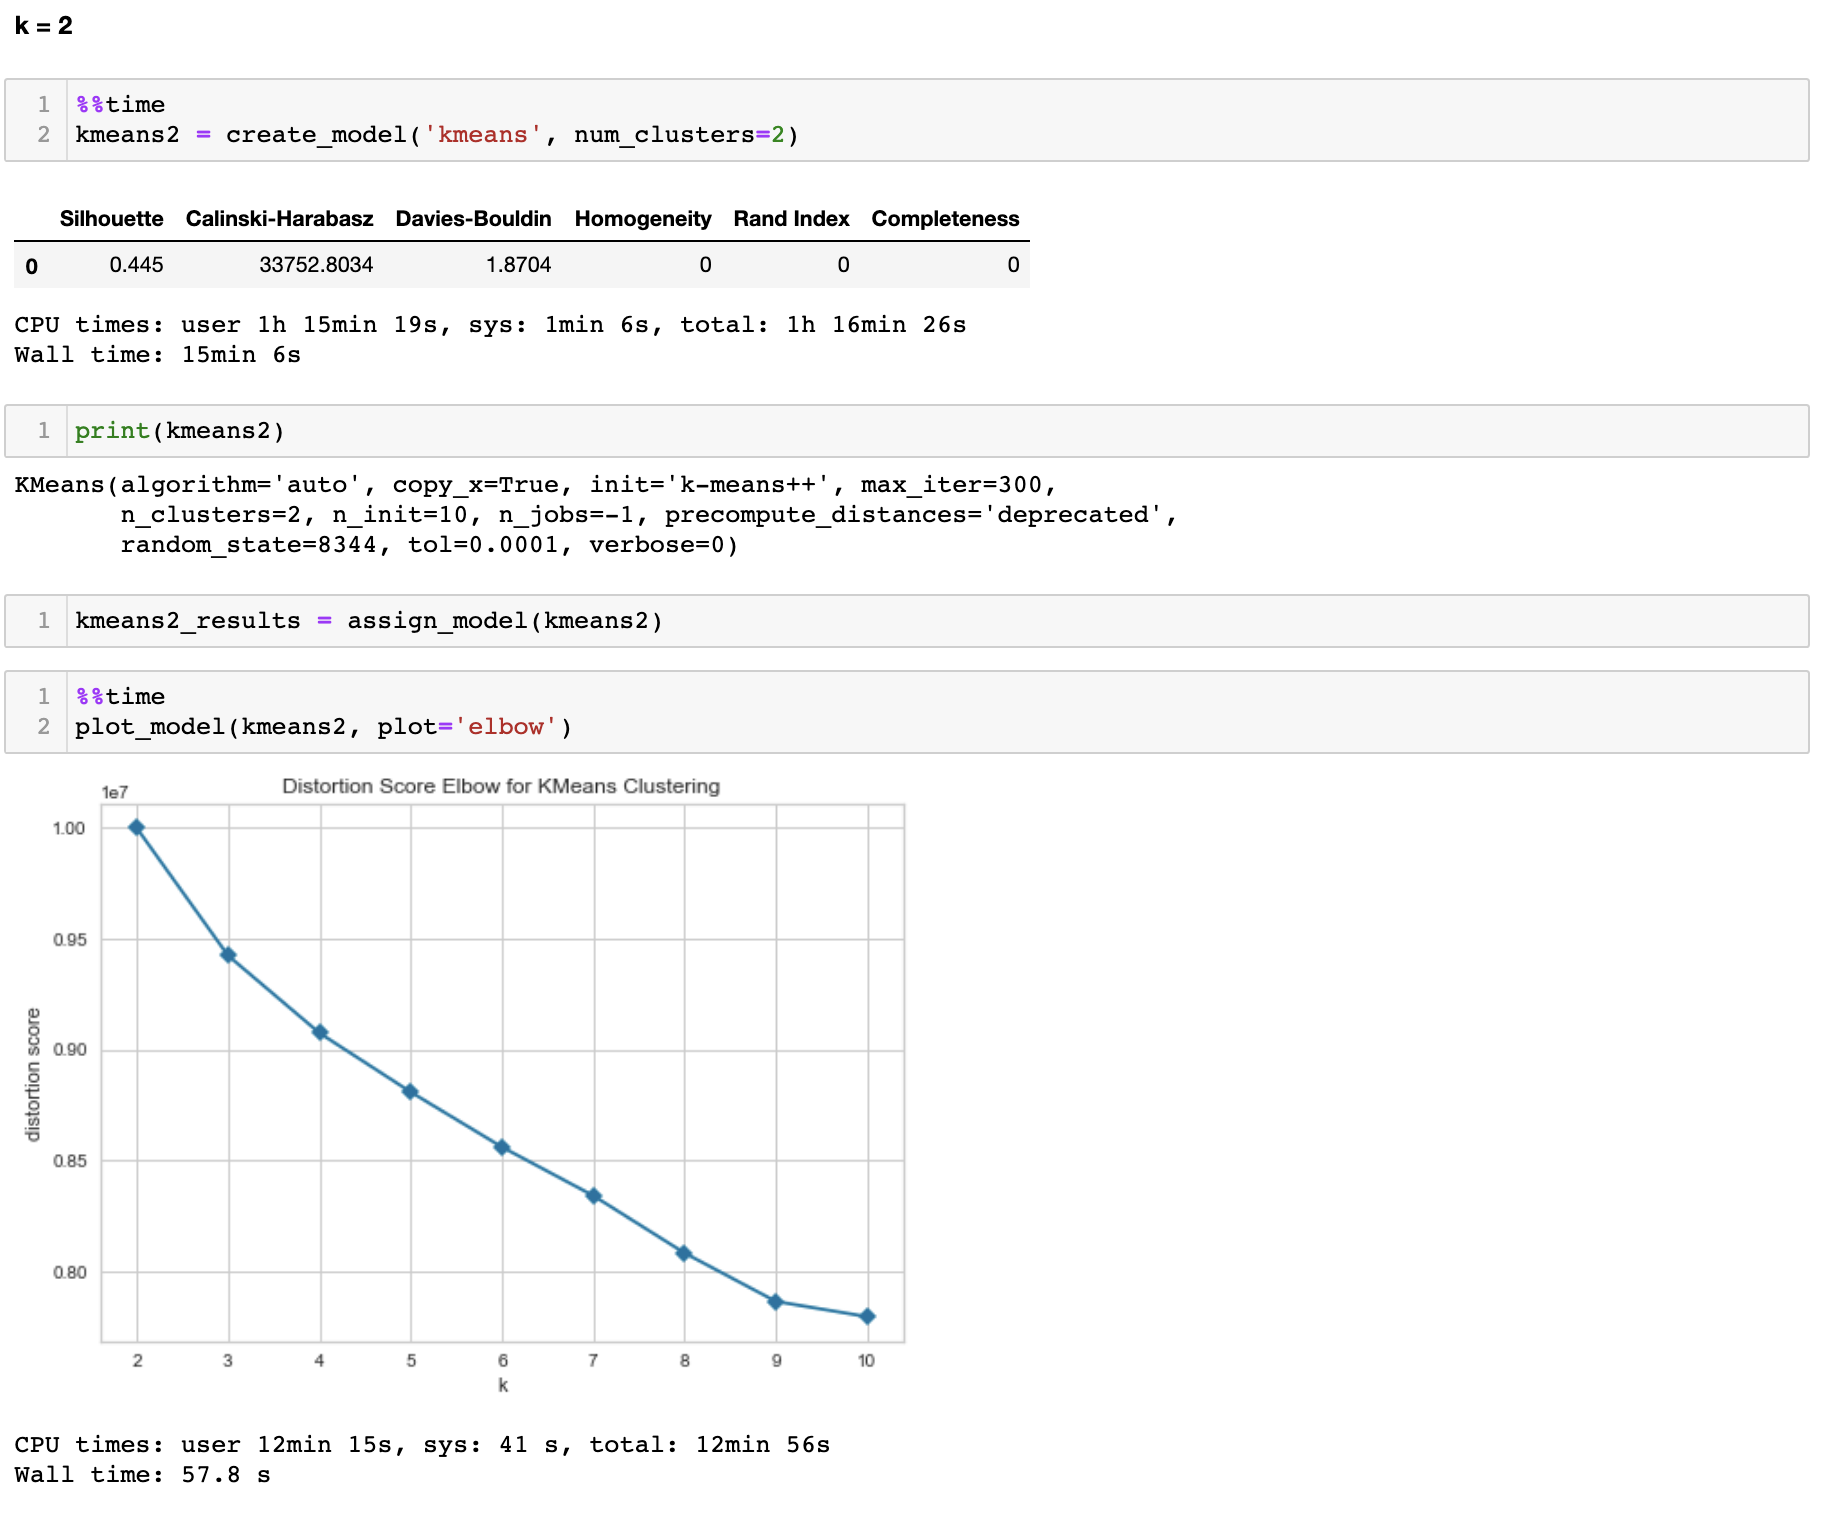

In [22]:
from IPython.display import Image
Image(filename = "./assets/BMED320_Damond_etal_2019_donor_6126_E08_pycaret_kmeans_2.png", width=800)

In [23]:
#%%time
#kmeans2 = create_model('kmeans', num_clusters=2)

In [24]:
#print(kmeans2)

In [25]:
#kmeans2_results = assign_model(kmeans2)

In [26]:
#%%time
#plot_model(kmeans2, plot='elbow')

In [27]:
##%%time
##plot_model(kmeans2, plot='silhouette')

**k = 3**

In [28]:
#%%time
#kmeans3 = create_model('kmeans', num_clusters=3)

In [29]:
#print(kmeans3)

In [30]:
#kmeans3_results = assign_model(kmeans3)

In [31]:
#%%time
#plot_model(kmeans3, plot='elbow')

In [32]:
#%%time
#plot_model(kmeans3, plot='silhouette')

**k = 4**

In [33]:
#%%time
#kmeans4 = create_model('kmeans', num_clusters=4)

In [34]:
#print(kmeans4)

In [35]:
#kmeans4_results = assign_model(kmeans4)

In [36]:
#%%time
#plot_model(kmeans4, plot='elbow')

In [37]:
#%%time
#plot_model(kmeans4, plot='silhouette')

# K-means clustering using `scikit-learn`

Conventional _k_-means requires only a few steps. The first step is to randomly select _k_ centroids, where _k_ is equal to the number of clusters you choose. **Centroids** are data points representing the center of a cluster.

The main element of the algorithm works by a two-step process called **expectation-maximization**. The expectation step assigns each data point to its nearest centroid. Then, the maximization step computes the mean of all the points for each cluster and sets the new centroid. Here’s what the conventional version of the k-means algorithm looks like:

![kmeans-algorithm](https://files.realpython.com/media/kmeans-algorithm.a94498a7ecd2.png)

The quality of the cluster assignments is determined by computing the **sum of the squared error** (**SSE**) after the centroids converge, or match the previous iteration’s assignment. The SSE is defined as the sum of the squared Euclidean distances of each point to its closest centroid. Since this is a measure of error, the objective of _k_-means is to try to minimize this value.

From: https://realpython.com/k-means-clustering-python

### Analyses of all channels jointly (K-means clustering)

In [38]:
# Min and max and number of voxels in the 2D IMC multichannel image
print('Min:', im.flatten().min())
print('Max:', im.flatten().max())
print('Number of voxels:', im.flatten().size)

Min: 0.0
Max: 1473.511
Number of voxels: 11118870


In [39]:
# Generally, we could use a tissue ROI mask for the slide. 
# We let this ROI be the whole first channel in the slide stack + 1, i.e.
im_msk = im[0,:,:]+1
print(im_msk.flatten().min())
print(im_msk.flatten().max())
im_msk.shape

1.0
378.168


(530, 567)

**Find all pixel locations in the ROI for extracting a dataset X and corresponding pixel locations to a Pandas data frame (dfROI)**

In [40]:
# Find voxel locations (ind_roi) corresponding to tissue ROI (value >=1 inside ROI, 0 else) 
ind_roi = np.where(im_msk > 0) 
X = np.transpose(np.asarray(im[:,ind_roi[0],ind_roi[1]])) # The pixel channel signatures within the ROI
print(X.shape)

(300510, 37)


In [41]:
# Check feature vectors (CyTOF pixel signatures) for the three first pixels
chn_names =  df_p_sort_chn['Metal Tag']
dfROI = pd.DataFrame(X, columns=chn_names)
dfROI.head(3)

Metal Tag      113In  115In  141Pr  142Nd   143Nd  144Nd  145Nd  146Nd  147Sm  \
0           1.066000  0.000    0.0  0.000  12.395  2.376    1.0  0.000    0.0   
1          11.754000  3.143    0.0  1.000   8.871  5.189    0.0  2.414    0.0   
2          18.483999  1.332    0.0  1.275   3.000  3.032    0.0  0.000    0.0   

Metal Tag  148Nd  ...  169Tm  170Er  171Yb  172Yb      173Yb  174Yb  175Yb  \
0          4.537  ...  0.000    0.0  4.739    2.0  62.405998  6.346    0.0   
1          6.969  ...  2.926    0.0  2.002    0.0  13.208000  5.364    0.0   
2          4.158  ...  2.928    0.0  6.211    0.0   1.000000  1.000    0.0   

Metal Tag  176Yb      191Ir      193Ir  
0            1.0   2.414000   0.000000  
1            0.0   4.589000  18.249001  
2            0.0  52.974998  66.415001  

[3 rows x 37 columns]

In [42]:
# The three last pixels signatures in the enumeration
dfROI.tail(3)

Metal Tag      113In  115In  141Pr  142Nd  143Nd  144Nd  145Nd  146Nd  147Sm  \
300507     29.274000  1.853    1.0    0.0  0.000  1.751  2.413  1.037    0.0   
300508     23.422001  0.000    0.0    0.0  1.029  1.344  0.000  0.000    0.0   
300509     16.829000  4.459    0.0    0.0  0.000  3.032  0.000  0.000    0.0   

Metal Tag  148Nd  ...  169Tm  170Er  171Yb  172Yb   173Yb  174Yb  175Yb  \
300507     0.000  ...    0.0    0.0    2.0    0.0  10.933  3.000    0.0   
300508     3.779  ...    0.0    0.0    0.0    0.0   9.376  0.000    0.0   
300509     0.000  ...    0.0    0.0    1.0    0.0  11.806  2.758    0.0   

Metal Tag  176Yb      191Ir      193Ir  
300507       1.0  30.969999  59.962002  
300508       0.0  20.679001  35.198002  
300509       1.0  12.137000  27.128000  

[3 rows x 37 columns]

**Insert pixel locations in the ROI**

In [43]:
dfROI.insert(loc = len(dfROI.columns),
           column = 'row',
           value = ind_roi[0])  # Row of pixel location
dfROI.insert(loc = len(dfROI.columns),
           column = 'col',
           value = ind_roi[1])  # Col of pixel location

In [44]:
dfROI.describe().T

count        mean         std  min      25%      50%  \
Metal Tag                                                            
113In      300510.0    8.517661    9.972184  0.0    2.008    5.181   
115In      300510.0    1.021032    1.811578  0.0    0.000    0.000   
141Pr      300510.0    0.202481    0.604651  0.0    0.000    0.000   
142Nd      300510.0    0.301524    0.681201  0.0    0.000    0.000   
143Nd      300510.0    1.285179    2.914566  0.0    0.000    0.000   
144Nd      300510.0    2.059365    5.361103  0.0    0.000    1.000   
145Nd      300510.0    4.323402   10.215173  0.0    0.000    1.000   
146Nd      300510.0    0.515797    1.319561  0.0    0.000    0.000   
147Sm      300510.0    0.383917    2.135539  0.0    0.000    0.000   
148Nd      300510.0    1.311738    1.943014  0.0    0.000    1.000   
149Sm      300510.0    0.049559    0.255444  0.0    0.000    0.000   
150Nd      300510.0    1.161979    1.802935  0.0    0.000    0.000   
152Sm      300510.0    0.165613    0.746011  0.0    0.000    0.000   
153Eu      300510.0    0.140065    6.134815  0.0    0.000    0.000   
154Sm      300510.0    1.718285   10.604997  0.0    0.000    0.000   
156Gd      300510.0    0.400722    2.487814  0.0    0.000    0.000   
158Gd      300510.0    3.292325    4.393186  0.0    0.000    1.975   
159Tb      300510.0    0.357444    1.129485  0.0    0.000    0.000   
160Gd      300510.0    2.723160    6.311198  0.0    0.000    0.000   
161Dy      300510.0    0.458988    1.530484  0.0    0.000    0.000   
162Dy      300510.0    0.142436    0.552329  0.0    0.000    0.000   
163Dy      300510.0    0.073966    0.329441  0.0    0.000    0.000   
164Dy      300510.0    0.970745    3.035182  0.0    0.000    0.000   
165Ho      300510.0    0.222431    0.734417  0.0    0.000    0.000   
166Er      300510.0    1.185089    2.493630  0.0    0.000    0.000   
167Er      300510.0    4.648904   19.884932  0.0    0.000    1.000   
168Er      300510.0    0.182662    0.794891  0.0    0.000    0.000   
169Tm      300510.0    0.502262    1.098088  0.0    0.000    0.000   
170Er      300510.0    0.026322    0.191846  0.0    0.000    0.000   
171Yb      300510.0    1.347567    1.581733  0.0    0.000    1.000   
172Yb      300510.0    0.488237    1.508189  0.0    0.000    0.000   
173Yb      300510.0    5.618832    8.166302  0.0    0.000    2.275   
174Yb      300510.0    1.918538    4.340158  0.0    0.000    1.000   
175Yb      300510.0    0.184065    1.042377  0.0    0.000    0.000   
176Yb      300510.0    0.345155    0.795875  0.0    0.000    0.000   
191Ir      300510.0    9.157948   11.175190  0.0    1.050    4.184   
193Ir      300510.0   17.319204   20.612888  0.0    2.601    7.691   
row        300510.0  264.500000  152.997804  0.0  132.000  264.500   
col        300510.0  283.000000  163.678819  0.0  141.000  283.000   

                  75%          max  
Metal Tag                           
113In       11.713000   377.167999  
115In        1.361000    84.235001  
141Pr        0.000000    24.330000  
142Nd        0.000000    13.905000  
143Nd        1.247000    71.648003  
144Nd        2.000000   241.634995  
145Nd        2.946000   164.412003  
146Nd        1.000000    59.875000  
147Sm        0.000000   136.531006  
148Nd        2.000000    58.181999  
149Sm        0.000000     5.356000  
150Nd        1.714000    31.313999  
152Sm        0.000000   206.410004  
153Eu        0.000000  1291.916992  
154Sm        0.000000   475.381012  
156Gd        0.000000   120.559998  
158Gd        4.493000   137.589996  
159Tb        0.000000    35.887001  
160Gd        2.000000    71.833000  
161Dy        0.000000    69.632004  
162Dy        0.000000    27.108999  
163Dy        0.000000    43.195999  
164Dy        1.478000  1473.510986  
165Ho        0.000000    49.605000  
166Er        1.419000   141.417999  
167Er        2.257000  1089.185059  
168Er        0.000000    37.337002  
169Tm        1.000000    18.938000  
170Er        0.000000     6.26400

In [45]:
dfROI_fn = './data/BMED320_experiments_case6126_E08_CyTOF_pixels.csv'
dfROI.to_csv(dfROI_fn, encoding='utf-8', index=False)

### Unsupervised classification of the 2D+CyTOF IMC data using K-means
Let X be the n x p data matrix, n = numper of samples (pixel signatures), p = feature vector dimension (number of channels)

In [46]:
X.shape

(300510, 37)

In [47]:
#chn_names = df.chn
chn_names[:5]

34    113In
28    115In
0     141Pr
25    142Nd
15    143Nd
Name: Metal Tag, dtype: object

#### Make data frame from unscaled X to check scaling

In [48]:
dX_unscaled = pd.DataFrame(X, columns=chn_names)
dX_unscaled.describe(percentiles = [0.5]).round(4).T

count     mean      std  min    50%        max
Metal Tag                                                   
113In      300510.0   8.5177   9.9722  0.0  5.181   377.1680
115In      300510.0   1.0210   1.8116  0.0  0.000    84.2350
141Pr      300510.0   0.2025   0.6047  0.0  0.000    24.3300
142Nd      300510.0   0.3015   0.6812  0.0  0.000    13.9050
143Nd      300510.0   1.2852   2.9146  0.0  0.000    71.6480
144Nd      300510.0   2.0594   5.3611  0.0  1.000   241.6350
145Nd      300510.0   4.3234  10.2152  0.0  1.000   164.4120
146Nd      300510.0   0.5158   1.3196  0.0  0.000    59.8750
147Sm      300510.0   0.3839   2.1355  0.0  0.000   136.5310
148Nd      300510.0   1.3117   1.9430  0.0  1.000    58.1820
149Sm      300510.0   0.0496   0.2554  0.0  0.000     5.3560
150Nd      300510.0   1.1620   1.8029  0.0  0.000    31.3140
152Sm      300510.0   0.1656   0.7460  0.0  0.000   206.4100
153Eu      300510.0   0.1401   6.1348  0.0  0.000  1291.9170
154Sm      300510.0   1.7183  10.6050  0.0  0.000   475.3810
156Gd      300510.0   0.4007   2.4878  0.0  0.000   120.5600
158Gd      300510.0   3.2923   4.3932  0.0  1.975   137.5900
159Tb      300510.0   0.3574   1.1295  0.0  0.000    35.8870
160Gd      300510.0   2.7232   6.3112  0.0  0.000    71.8330
161Dy      300510.0   0.4590   1.5305  0.0  0.000    69.6320
162Dy      300510.0   0.1424   0.5523  0.0  0.000    27.1090
163Dy      300510.0   0.0740   0.3294  0.0  0.000    43.1960
164Dy      300510.0   0.9707   3.0352  0.0  0.000  1473.5110
165Ho      300510.0   0.2224   0.7344  0.0  0.000    49.6050
166Er      300510.0   1.1851   2.4936  0.0  0.000   141.4180
167Er      300510.0   4.6489  19.8849  0.0  1.000  1089.1851
168Er      300510.0   0.1827   0.7949  0.0  0.000    37.3370
169Tm      300510.0   0.5023   1.0981  0.0  0.000    18.9380
170Er      300510.0   0.0263   0.1918  0.0  0.000     6.2640
171Yb      300510.0   1.3476   1.5817  0.0  1.000    20.5310
172Yb      300510.0   0.4882   1.5082  0.0  0.000    52.5890
173Yb      300510.0   5.6188   8.1663  0.0  2.275   102.5560
174Yb      300510.0   1.9185   4.3402  0.0  1.000   108.2610
175Yb      300510.0   0.1841   1.0424  0.0  0.000   337.2610
176Yb      300510.0   0.3452   0.7959  0.0  0.000   159.1550
191Ir      300510.0   9.1579  11.1752  0.0  4.184   140.7420
193Ir      300510.0  17.3192  20.6129  0.0  7.691   298.3140

### Scaling* of feature vectors (IMC signals), channel-by-channel wthin the ROI mask
*) Scaling to zero mean and unit standard deviation

In [49]:
scaler = StandardScaler()  
scaler.fit(X.astype(float))

X_scaled = scaler.transform(X.astype(float))  

# Make data frame from scaled X to check scaling
dX_scaled = pd.DataFrame(X_scaled, columns=chn_names)
dX_scaled.head().T

0         1         2         3         4
Metal Tag                                                  
113In     -0.747246  0.324537  0.999415  0.706600  1.132686
115In     -0.563615  1.171339  0.171656  1.163610  0.540396
141Pr     -0.334873 -0.334873 -0.334873 -0.334873 -0.334873
142Nd     -0.442636  1.025362  1.429061 -0.442636 -0.442636
143Nd      3.811833  2.602732  0.588363 -0.097846 -0.440951
144Nd      0.059062  0.583768  0.181425  0.012429  0.175456
145Nd     -0.325340 -0.423234 -0.423234 -0.236061 -0.423234
146Nd     -0.390886  1.438514 -0.390886 -0.390886 -0.390886
147Sm     -0.179775 -0.179775 -0.179775  0.288491 -0.179775
148Nd      1.659931  2.911597  1.464873 -0.675106 -0.675106
149Sm     -0.194010 -0.194010 -0.194010 -0.194010 -0.194010
150Nd     -0.063774 -0.089842 -0.089842 -0.644494  0.526376
152Sm     -0.221999 -0.221999 -0.221999 -0.221999  1.118467
153Eu     -0.022831 -0.022831 -0.022831 -0.022831 -0.022831
154Sm     -0.067731 -0.162026 -0.162026 -0.162026 -0.162026
156Gd     -0.161074 -0.161074 -0.161074 -0.161074 -0.161074
158Gd     -0.212221  0.421489  2.898966  0.721044  2.784243
159Tb      0.568894  0.918612 -0.316467 -0.316467 -0.316467
160Gd     -0.114584 -0.273033 -0.431481 -0.431481 -0.431481
161Dy      3.016705  2.583508  1.205511  0.353491 -0.299898
162Dy     -0.257884 -0.257884 -0.257884 -0.257884 -0.257884
163Dy     -0.224520  5.245357 -0.224520 -0.224520  2.810928
164Dy     -0.319831  0.416205  0.015569  0.377657 -0.319831
165Ho     -0.302868 -0.302868 -0.302868 -0.302868 -0.302868
166Er      0.468359  0.874996  1.236317 -0.074225 -0.074225
167Er     -0.233791 -0.113247 -0.133212 -0.183501 -0.233791
168Er     -0.229795 -0.229795  2.189409 -0.229795 -0.229795
169Tm     -0.457398  2.207239  2.209060  4.482105  4.454785
170Er     -0.137205 -0.137205 -0.137205 -0.137205 -0.137205
171Yb      2.144128  0.413745  3.074754 -0.851957  0.815204
172Yb      1.002371 -0.323724 -0.323724 -0.323724  0.031669
173Yb      6.953853  0.929329 -0.565598 -0.688052 -0.688052
174Yb      1.020117  0.793858 -0.211637 -0.442044 -0.211637
175Yb     -0.176582 -0.176582 -0.176582  0.922830 -0.176582
176Yb      0.822800 -0.433681 -0.433681 -0.433681 -0.433681
191Ir     -0.603476 -0.408848  3.920929  2.731059  2.022076
193Ir     -0.840214  0.045108  2.381805  3.114551  3.069628

In [50]:
dX_scaled.describe(percentiles = [0.5]).round(4).T

count  mean  std     min     50%       max
Metal Tag                                               
113In      300510.0   0.0  1.0 -0.8541 -0.3346   36.9679
115In      300510.0  -0.0  1.0 -0.5636 -0.5636   45.9346
141Pr      300510.0  -0.0  1.0 -0.3349 -0.3349   39.9033
142Nd      300510.0  -0.0  1.0 -0.4426 -0.4426   19.9699
143Nd      300510.0  -0.0  1.0 -0.4410 -0.4410   24.1418
144Nd      300510.0  -0.0  1.0 -0.3841 -0.1976   44.6878
145Nd      300510.0   0.0  1.0 -0.4232 -0.3253   15.6717
146Nd      300510.0   0.0  1.0 -0.3909 -0.3909   44.9841
147Sm      300510.0  -0.0  1.0 -0.1798 -0.1798   63.7531
148Nd      300510.0   0.0  1.0 -0.6751 -0.1604   29.2691
149Sm      300510.0  -0.0  1.0 -0.1940 -0.1940   20.7734
150Nd      300510.0  -0.0  1.0 -0.6445 -0.6445   16.7239
152Sm      300510.0  -0.0  1.0 -0.2220 -0.2220  276.4635
153Eu      300510.0  -0.0  1.0 -0.0228 -0.0228  210.5653
154Sm      300510.0  -0.0  1.0 -0.1620 -0.1620   44.6642
156Gd      300510.0  -0.0  1.0 -0.1611 -0.1611   48.2992
158Gd      300510.0  -0.0  1.0 -0.7494 -0.2999   30.5696
159Tb      300510.0  -0.0  1.0 -0.3165 -0.3165   31.4565
160Gd      300510.0   0.0  1.0 -0.4315 -0.4315   10.9504
161Dy      300510.0  -0.0  1.0 -0.2999 -0.2999   45.1969
162Dy      300510.0   0.0  1.0 -0.2579 -0.2579   48.8234
163Dy      300510.0   0.0  1.0 -0.2245 -0.2245  130.8947
164Dy      300510.0  -0.0  1.0 -0.3198 -0.3198  485.1580
165Ho      300510.0  -0.0  1.0 -0.3029 -0.3029   67.2406
166Er      300510.0   0.0  1.0 -0.4752 -0.4752   56.2366
167Er      300510.0   0.0  1.0 -0.2338 -0.1835   54.5407
168Er      300510.0   0.0  1.0 -0.2298 -0.2298   46.7415
169Tm      300510.0  -0.0  1.0 -0.4574 -0.4574   16.7890
170Er      300510.0   0.0  1.0 -0.1372 -0.1372   32.5141
171Yb      300510.0  -0.0  1.0 -0.8520 -0.2197   12.1281
172Yb      300510.0  -0.0  1.0 -0.3237 -0.3237   34.5453
173Yb      300510.0   0.0  1.0 -0.6881 -0.4095   11.8704
174Yb      300510.0  -0.0  1.0 -0.4420 -0.2116   24.5020
175Yb      300510.0  -0.0  1.0 -0.1766 -0.1766  323.3737
176Yb      300510.0   0.0  1.0 -0.4337 -0.4337  199.5416
191Ir      300510.0  -0.0  1.0 -0.8195 -0.4451   11.7747
193Ir      300510.0   0.0  1.0 -0.8402 -0.4671   13.6320

**Fit the K-means model to the data (and time it)**

In [51]:
K = 3  # Number of clusters (7 is "nice")
max_iter = 300 # Max number of iteration
tol = 0.0001 # Tolerance
kmeans_model = KMeans(n_clusters=K, random_state=42, max_iter=max_iter, tol=tol)
print(kmeans_model)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=10, n_jobs='deprecated',
       precompute_distances='deprecated', random_state=42, tol=0.0001,
       verbose=0)


In [52]:
%%time
kmeans_fit = kmeans_model.fit(X_scaled)

CPU times: user 36.6 s, sys: 1.8 s, total: 38.4 s
Wall time: 2.75 s


In [53]:
print(kmeans_fit.labels_)
print('First centroid in p-dimensional feature vector space:\n', kmeans_fit.cluster_centers_[0,:])

[1 1 2 ... 2 2 2]
First centroid in p-dimensional feature vector space:
 [-0.0490794  -0.12950276  1.24679613  0.68843688 -0.31644633  2.0320387
  2.76417852  0.82547607 -0.04782499  0.85367874  0.20587082 -0.16624042
  0.5132456   0.13726019  1.51509563  1.38012404  1.00476985  0.89965362
  2.89867031  0.18657654  0.00714536  0.04953365 -0.05522623  0.07755037
 -0.12855642  1.84007121  1.41953496  1.4951212   0.51681775 -0.06527434
  0.0678662  -0.21092321  2.31320312  0.17855404  0.78949861 -0.34773327
 -0.35622451]


In [54]:
print(plt.style.available)

['Solarize_Light2', '_classic_test_patch', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn', 'seaborn-bright', 'seaborn-colorblind', 'seaborn-dark', 'seaborn-dark-palette', 'seaborn-darkgrid', 'seaborn-deep', 'seaborn-muted', 'seaborn-notebook', 'seaborn-paper', 'seaborn-pastel', 'seaborn-poster', 'seaborn-talk', 'seaborn-ticks', 'seaborn-white', 'seaborn-whitegrid', 'tableau-colorblind10']


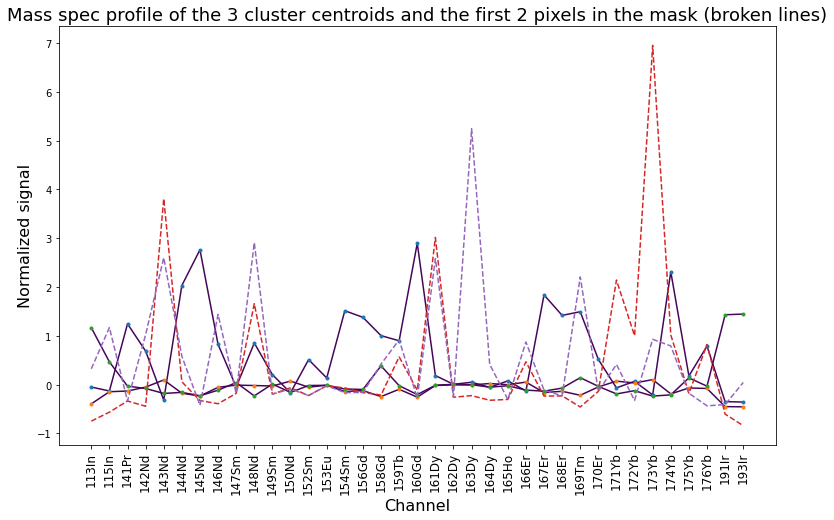

In [55]:
# Plot the cluster centroids as line plots

nv = 2

my_cmap = mpl.colors.ListedColormap(['red', '#000000','#444444', '#666666', '#ffffff', 'blue', 'orange'])
my_cmap_v = plt.cm.viridis(K)

fig, ax = plt.subplots(1,1)

fig.set_size_inches(12, 7)

plt.plot(kmeans_fit.cluster_centers_.T, color=my_cmap_v)
plt.plot(kmeans_fit.cluster_centers_.T, '.')
plt.plot(X_scaled[:nv, :].T, '--')
plt.xlabel('Channel', fontsize=16)
ax.set_xticks([x for x in range(X_scaled.shape[1])])
ax.set_xticklabels(chn_names, rotation='vertical', fontsize=12)
plt.ylabel('Normalized signal', fontsize=16)
#plt.xlim(0, 3)
plt.title('Mass spec profile of the %d cluster centroids and the first %d pixels in the mask (broken lines)' % (K, nv), fontsize=18)

plt.subplots_adjust(bottom=.12, top=.95, right=.95, left=.12)

plt.show()

**Make a k-means segmented image (segmentation restricted to the ROI)**

In [56]:
kmeans_segm = 0 * im_msk.copy()
print('Size of segmented image:', kmeans_segm.shape)
print('min:', kmeans_fit.labels_.min())
print('max:', kmeans_fit.labels_.max())
print('Number of clustered samples within ROI:', len(ind_roi[0]))

Size of segmented image: (530, 567)
min: 0
max: 2
Number of clustered samples within ROI: 300510


**Assign the cluster belonging to each voxel within the ROI**

In [57]:
for v in range(len(ind_roi[0])):
    kmeans_segm[ind_roi[0][v], ind_roi[1][v]] = kmeans_fit.labels_[v]

In [58]:
# https://gist.github.com/jakevdp/91077b0cae40f8f8244a  By Jake VanderPlas
def discrete_cmap(N, base_cmap=None):
    """Create an N-bin discrete colormap from the specified input map"""

    # Note that if base_cmap is a string or None, you can simply do
    #    return plt.cm.get_cmap(base_cmap, N)
    # The following works for string, None, or a colormap instance:

    base = plt.cm.get_cmap(base_cmap)
    color_list = base(np.linspace(0, 1, N))
    cmap_name = base.name + str(N)
    return base.from_list(cmap_name, color_list, N)

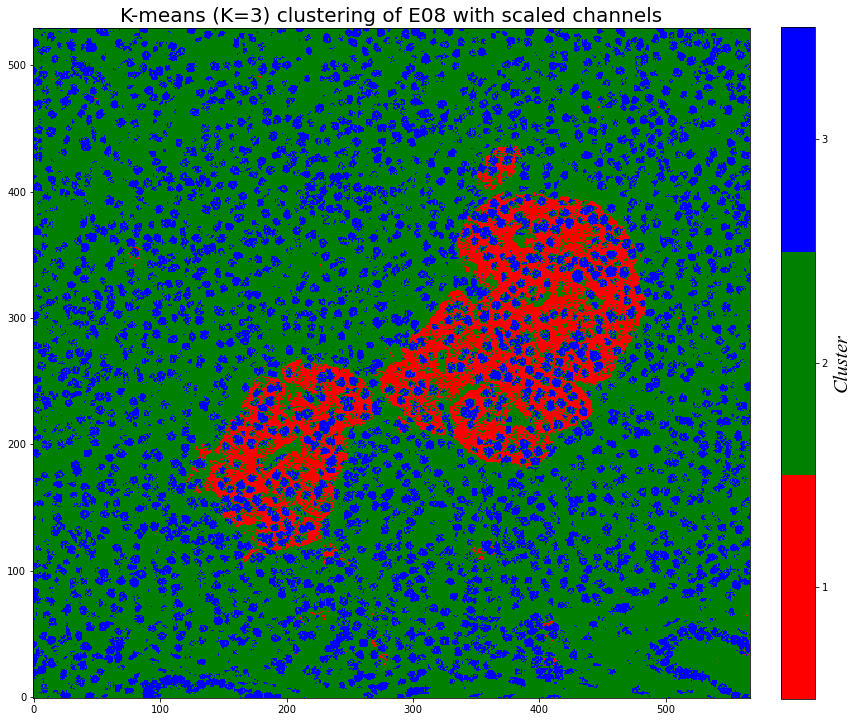

In [59]:
fig_fn = '%s/BMED320_experiments_case6126_E08_K_means_clustering_with_K_3.pdf' % fn_fig_base

fig, axes = plt.subplots(1,1, figsize=(14,14))

# Possible colormaps: 'gray', 'jet', 'cubehelix', 
if K==7:
    my_cmap = mpl.colors.ListedColormap(['red', '#000000','#444444', '#666666', '#ffffff', 'blue', 'orange'])
elif K==3:
    my_cmap = mpl.colors.ListedColormap(['red','green','blue'])
else:
    my_cmap = 'jet'
    
#plt.imshow(np.flip(kmeans_segm[:, :], axis=0), cmap=discrete_cmap(K, 'gray'), origin='lower') 
plt.imshow(np.flip(kmeans_segm[:, :], axis=0), cmap=my_cmap, origin='lower') 

# See: https://stackoverflow.com/questions/18195758/set-matplotlib-colorbar-size-to-match-graph
im_ratio = kmeans_segm.shape[0]/kmeans_segm.shape[1]
cb = plt.colorbar(label='Cluster', orientation='vertical', fraction=0.046*im_ratio, pad=0.04)
ax = cb.ax
text = ax.yaxis.label
font = mpl.font_manager.FontProperties(family='times new roman', style='italic', size=20)
text.set_font_properties(font)

plt.clim(-0.5, K - 0.5)
labels = np.arange(0,K,1)
cb.set_ticks(labels)
cb.set_ticklabels(labels+1)  # cluster numbering from 1,2,...,K
plt.title('K-means (K=%d) clustering of E08 with scaled channels' % (K), size=20)
plt.savefig(fig_fn, bbox_inches='tight')
plt.show()

### Choosing the Appropriate Number of Clusters
There are two methods that are commonly used to evaluate the appropriate number of clusters:

- The **elbow method**
- The **silhouette coefficient**

These are often used as complementary evaluation techniques rather than one being preferred over the other. 




To perform the **elbow method**, run several _k_-means, increment _k_ with each iteration, and record the SSE:

In [60]:
%%time
kmeans_kwargs = {
    "init": "random",
    "n_init": 10,
    "max_iter": 300,
    "random_state": 42,
}

# A list holds the SSE values for each k
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(X_scaled)
    print('K =', k, 'SSE =', kmeans.inertia_)
    sse.append(kmeans.inertia_)

K = 1 SSE = 11118870.00000393
K = 2 SSE = 9995951.916494936
K = 3 SSE = 9421984.75253879
K = 4 SSE = 9073730.691493928
K = 5 SSE = 8812626.710806435
K = 6 SSE = 8590533.339506952
K = 7 SSE = 8408911.826502776
K = 8 SSE = 8188282.397457687
K = 9 SSE = 8061194.008143309
K = 10 SSE = 7901750.555723438
CPU times: user 12min 26s, sys: 24.3 s, total: 12min 51s
Wall time: 50.8 s


There’s a sweet spot where the SSE curve starts to bend known as the **elbow point**. The x-value of this point is thought to be a reasonable trade-off between error and number of clusters. 

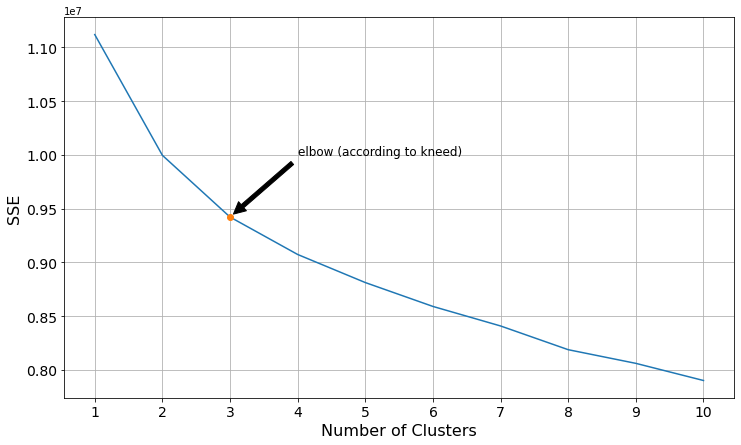

In [61]:
fig_fn = '%s/BMED320_experiments_case6126_E08_kneed_elbow_number_of_clusters.pdf' % fn_fig_base

fig, ax = plt.subplots(1,1)
fig.set_size_inches(12, 7)
plt.plot(range(1, 11), sse)
plt.xticks(range(1, 11))
plt.xlabel("Number of Clusters", size=16)
plt.ylabel("SSE", size=16)
plt.xticks(fontsize=14, rotation=0)
plt.yticks(fontsize=14, rotation=0)

#annotation
plt.plot([3], [sse[3-1]], 'o')
plt.annotate('elbow (according to kneed)', xy=(3, sse[3-1]), xytext=(3+1, sse[3-2]), fontsize=12,
            arrowprops=dict(facecolor='black', shrink=0.05))

plt.grid()
plt.savefig(fig_fn, bbox_inches='tight')
plt.show()

If the elbow point of the curve is difficult to decide, one could use the Python package [`kneed`](https://github.com/arvkevi/kneed), to identify the elbow point programmatically.

In [62]:
from kneed import KneeLocator
kl = KneeLocator(
    range(1, 11), sse, curve="convex", direction="decreasing"
)

print('Sweet spot elbow point: K=', kl.elbow)

Sweet spot elbow point: K= 3


The **silhouette coefficient** is a measure of cluster cohesion and separation. It quantifies how well a data point fits into its assigned cluster based on two factors:

- How close the data point is to other points in the cluster
- How far away the data point is from points in other clusters
Silhouette coefficient values range between -1 and 1. Larger numbers indicate that samples are closer to their clusters than they are to other clusters.

In the scikit-learn [implementation](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html) of the silhouette coefficient, the average silhouette coefficient of all the samples is summarized into one score. The silhouette score() function needs a minimum of two clusters, or it will raise an exception. More specifically:

The Silhouette Coefficient is calculated using the mean intra-cluster distance (a) and the mean nearest-cluster distance (b) for each sample. The Silhouette Coefficient for a sample is (b - a) / max(a, b). To clarify, b is the distance between a sample and the nearest cluster that the sample is not a part of. Note that Silhouette Coefficient is only defined if number of labels is 2 <= n_labels <= n_samples - 1.

The value of the Silhouette score varies from -1 to 1. If the score is 1, the cluster is dense and well-separated than other clusters. A value near 0 represents overlapping clusters with samples very close to the decision boundary of the neighboring clusters. A negative score [-1, 0] indicates that the samples might have got assigned to the wrong clusters.

The Python scikit-learn package supports the following different methods for evaluating Silhouette scores.

- [silhouette_score](https://scikit-learn.org/stable/modules/clustering.html#silhouette-coefficient) (sklearn.metrics) for the data set is used for measuring the mean of the Silhouette Coefficient for each sample belonging to different clusters.
- [silhouette_samples](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_samples.html) (sklearn.metrics) provides the Silhouette scores for each sample of different clusters.

Sources to consult:<br>
- https://dzone.com/articles/kmeans-silhouette-score-explained-with-python-exam
- https://towardsdatascience.com/silhouette-method-better-than-elbow-method-to-find-optimal-clusters-378d62ff6891
- https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html#sphx-glr-auto-examples-cluster-plot-kmeans-silhouette-analysis-py

**Test example from scikit-learn:**

For n_clusters = 2 The average silhouette_score is : 0.7049787496083262
For n_clusters = 3 The average silhouette_score is : 0.5882004012129721
For n_clusters = 4 The average silhouette_score is : 0.6505186632729437
For n_clusters = 5 The average silhouette_score is : 0.5745566973301872
For n_clusters = 6 The average silhouette_score is : 0.4387644975296138


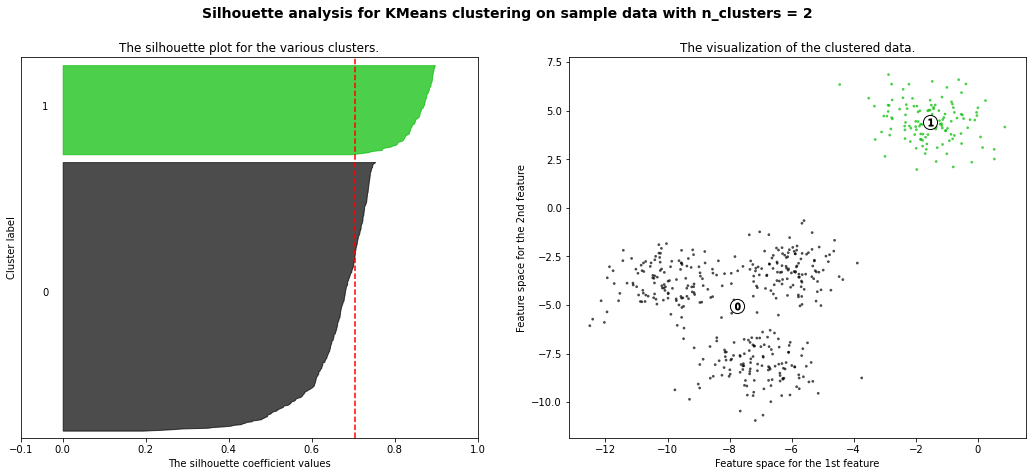

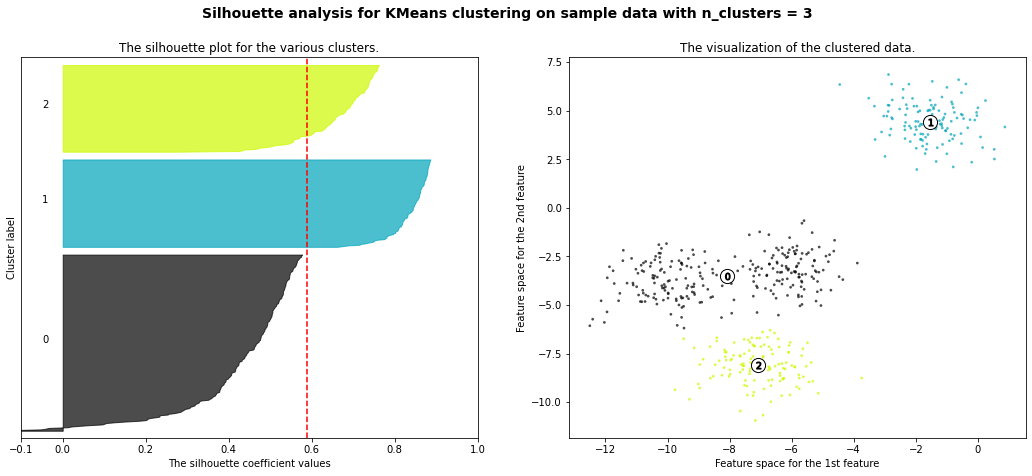

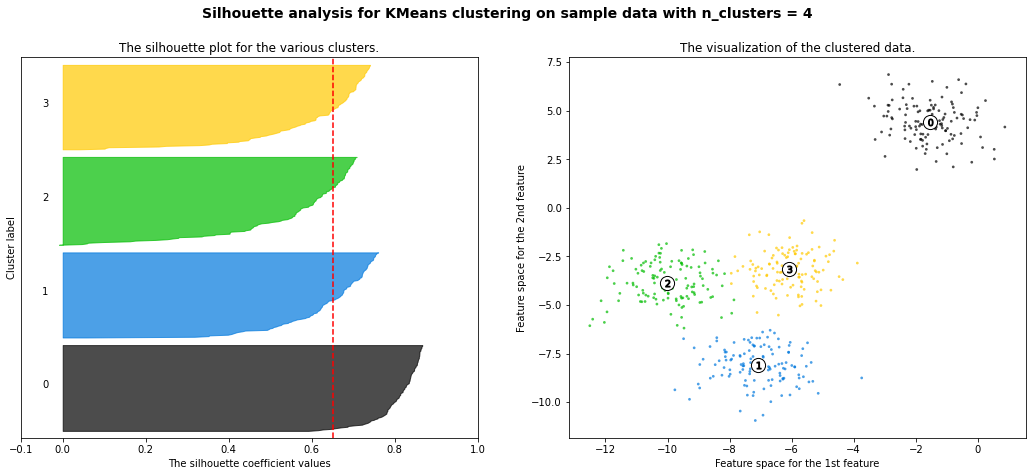

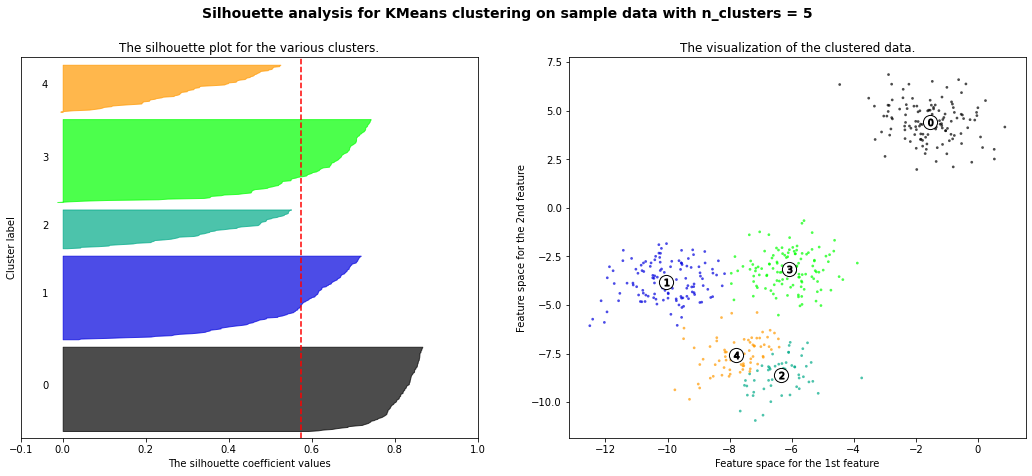

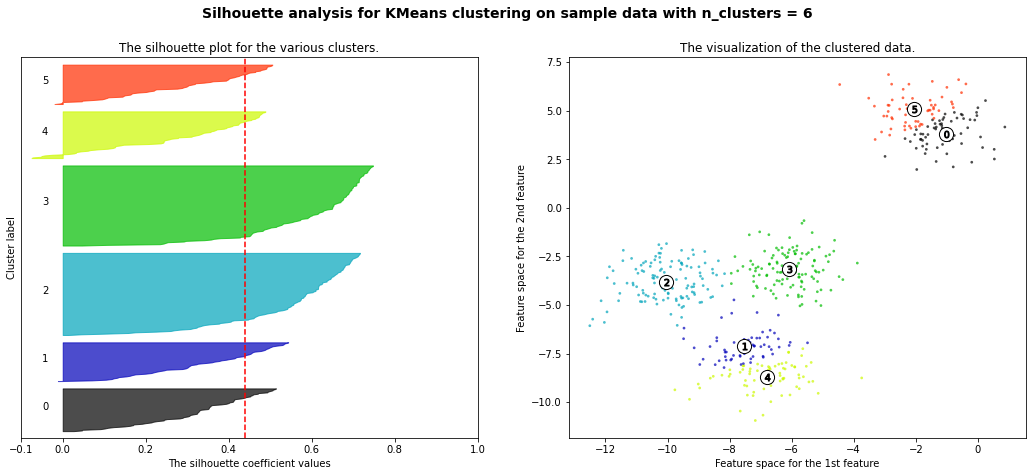

In [63]:
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np


# Generating the sample data from make_blobs
# This particular setting has one distinct cluster and 3 clusters placed close
# together.
X, y = make_blobs(n_samples=500,
                  n_features=2,
                  centers=4,
                  cluster_std=1,
                  center_box=(-10.0, 10.0),
                  shuffle=True,
                  random_state=1)  # For reproducibility

range_n_clusters = [2, 3, 4, 5, 6]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

Observations from above Silhouette Plots:

- The silhouette plot shows that the n_cluster value of 3 is a bad pick, as all the points in the cluster with cluster_label=0 are below-average silhouette scores.
- The silhouette plot shows that the n_cluster value of 5 is a bad pick, as all the points in the cluster with cluster_label=2 and 4 are below-average silhouette scores.
- The silhouette plot shows that the n_cluster value of 6 is a bad pick, as almost all the points in the cluster with cluster_label=0,1,4 and 5 are below-average silhouette scores, and also due to the presence of outliers.
- Silhouette analysis is more ambivalent in deciding between 2 and 4.
- The thickness of the silhouette plot for the cluster with cluster_label=0 when n_clusters=2, is bigger in size owing to the grouping of the 3 sub-clusters into one big cluster.
- For n_clusters=4, all the plots are more or less of similar thickness and hence are of similar sizes, as can be considered as best ‘k’.


Using `scikit-learn.metrics` on our IMC data, loop through values of k again, computing the silhouette coefficient (this takes a LOOONG time i.e. ~2 hr wall time):

```python
%%time
from sklearn.metrics import silhouette_score

# A list holds the silhouette coefficients for each k
silhouette_coefficients = []

# Notice you start at 2 clusters for silhouette coefficient
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(X_scaled)
    score = silhouette_score(X_scaled, kmeans.labels_)
    print('K =', k, 'silhouette score =', score)
    silhouette_coefficients.append(score)
```

```
K = 2 silhouette score = 0.44510556032557064
K = 3 silhouette score = 0.13272987832688307
K = 4 silhouette score = 0.13636804789058554
K = 5 silhouette score = 0.1394940962768057
K = 6 silhouette score = 0.13849795323564695
K = 7 silhouette score = 0.1409242340951432
K = 8 silhouette score = 0.07781204586066344
K = 9 silhouette score = 0.06489030156571994
K = 10 silhouette score = 0.07091744256577782
CPU times: user 5h 11min 1s, sys: 51min 15s, total: 6h 2min 16s
Wall time: 1h 56min 58s
```

Plotting the average silhouette scores for each _k_ shows that the best choice for _k_ is 3 since it has the maximum score:

In [64]:
silhouette_coefficients = [0.44510556032557064,
 0.13272987832688307,
 0.13636804789058554,
 0.1394940962768057,
 0.13849795323564695,
 0.1409242340951432,
 0.07781204586066344,
 0.06489030156571994,
 0.07091744256577782]

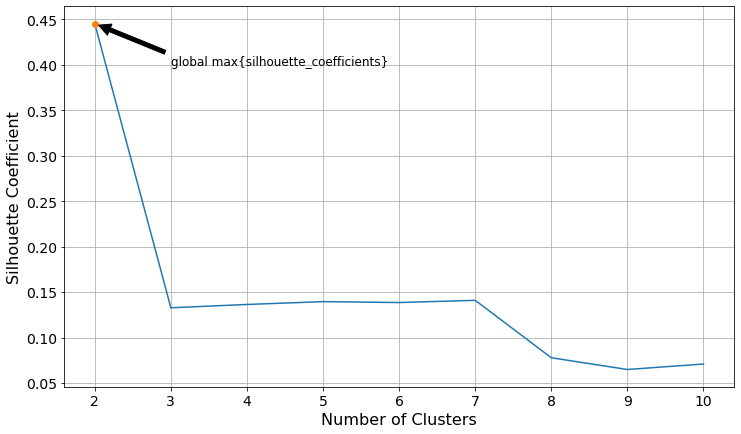

In [65]:
fig_fn = '%s/BMED320_experiments_case6126_E08_silhouette_coefficient_number_of_clusters.pdf' % fn_fig_base
#plt.style.use("fivethirtyeight")

fig, ax = plt.subplots(1,1)
fig.set_size_inches(12, 7)


plt.plot(range(2, 11), silhouette_coefficients)
plt.xticks(range(2, 11))
plt.xlabel("Number of Clusters", size=16)
plt.ylabel("Silhouette Coefficient", size=16)
plt.xticks(fontsize=14, rotation=0)
plt.yticks(fontsize=14, rotation=0)

# annotation
y_adhoc = 0.4
plt.plot([2], [silhouette_coefficients[2-2]], 'o')
plt.annotate('global max{silhouette_coefficients}', xy=(2, silhouette_coefficients[2-2]), 
             xytext=(2+1, y_adhoc), fontsize=12,
            arrowprops=dict(facecolor='black', shrink=0.05))

plt.grid()
plt.savefig(fig_fn, bbox_inches='tight')
plt.show()

Ultimately, your decision on the number of clusters to use should be guided by a combination of domain knowledge and clustering evaluation metrics.

```python
%%time
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np


fig_fn = '%s/BMED320_experiments_case6126_E08_silhouette_scores_of_clusters.pdf' % fn_fig_base

range_n_clusters = [2, 3, 4, 5, 6]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 1 column
    fig, ax = plt.subplots(1, 1)
    fig.set_size_inches(18, 7)

    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax.set_ylim([0, len(X_scaled) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X_scaled)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X_scaled, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X_scaled, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax.set_title("The silhouette plot for the various clusters.")
    ax.set_xlabel("The silhouette coefficient values")
    ax.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax.set_yticks([])  # Clear the yaxis labels / ticks
    ax.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    plt.suptitle(("Silhouette analysis for KMeans clustering on IMC data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.savefig(fig_fn, bbox_inches='tight')
plt.show()
```

```python
For n_clusters = 2 The average silhouette_score is : 0.4451465877506853
For n_clusters = 3 The average silhouette_score is : 0.13284362598409535
For n_clusters = 4 The average silhouette_score is : 0.13611037518871638
For n_clusters = 5 The average silhouette_score is : 0.13892110255788137
For n_clusters = 6 The average silhouette_score is : 0.13957083093593337

CPU times: user 5h 33min 8s, sys: 56min 44s, total: 6h 29min 52s
Wall time: 2h 10min 5s
```

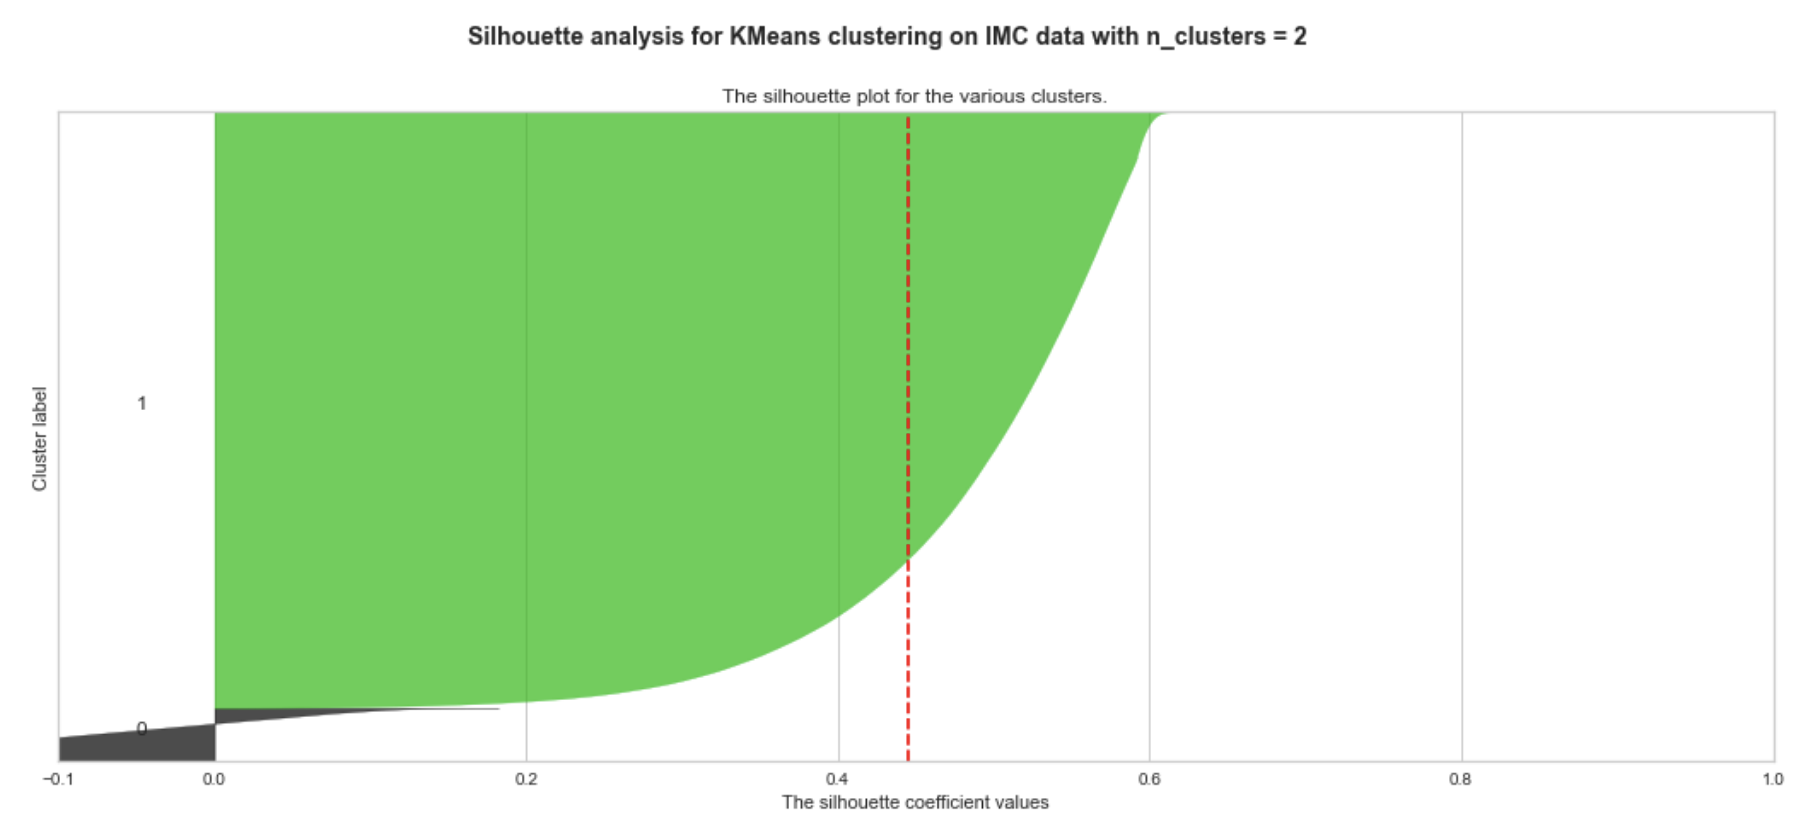

In [66]:
from IPython.display import Image
Image(filename='./assets/silhouette_2.png', width=600)

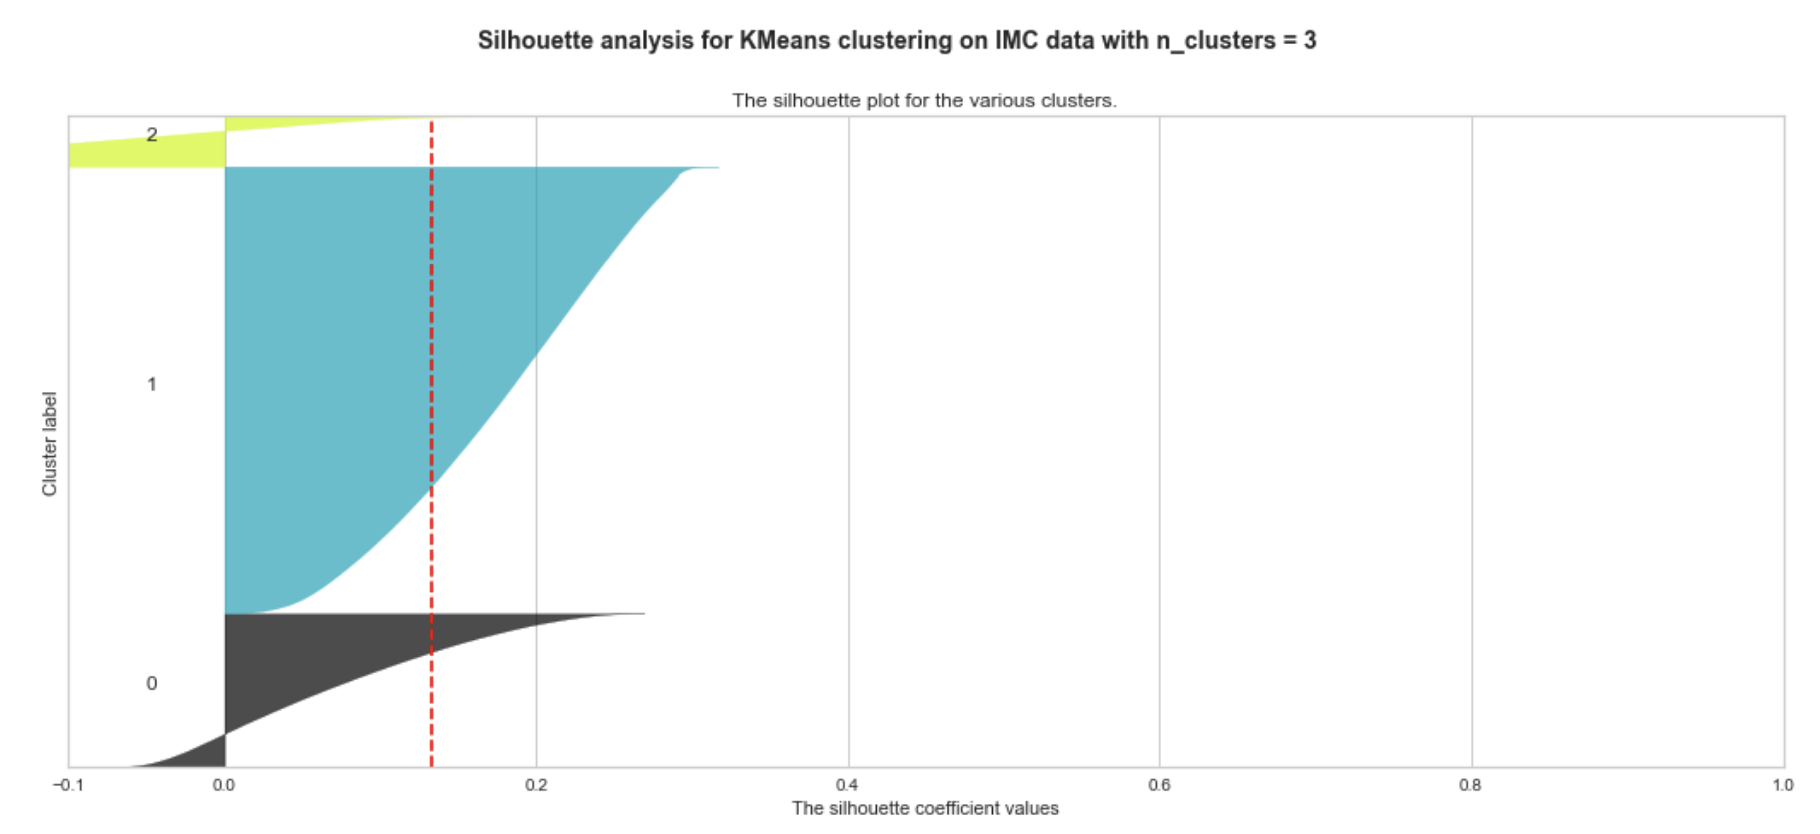

In [67]:
from IPython.display import Image
Image(filename='./assets/silhouette_3.png', width=600)

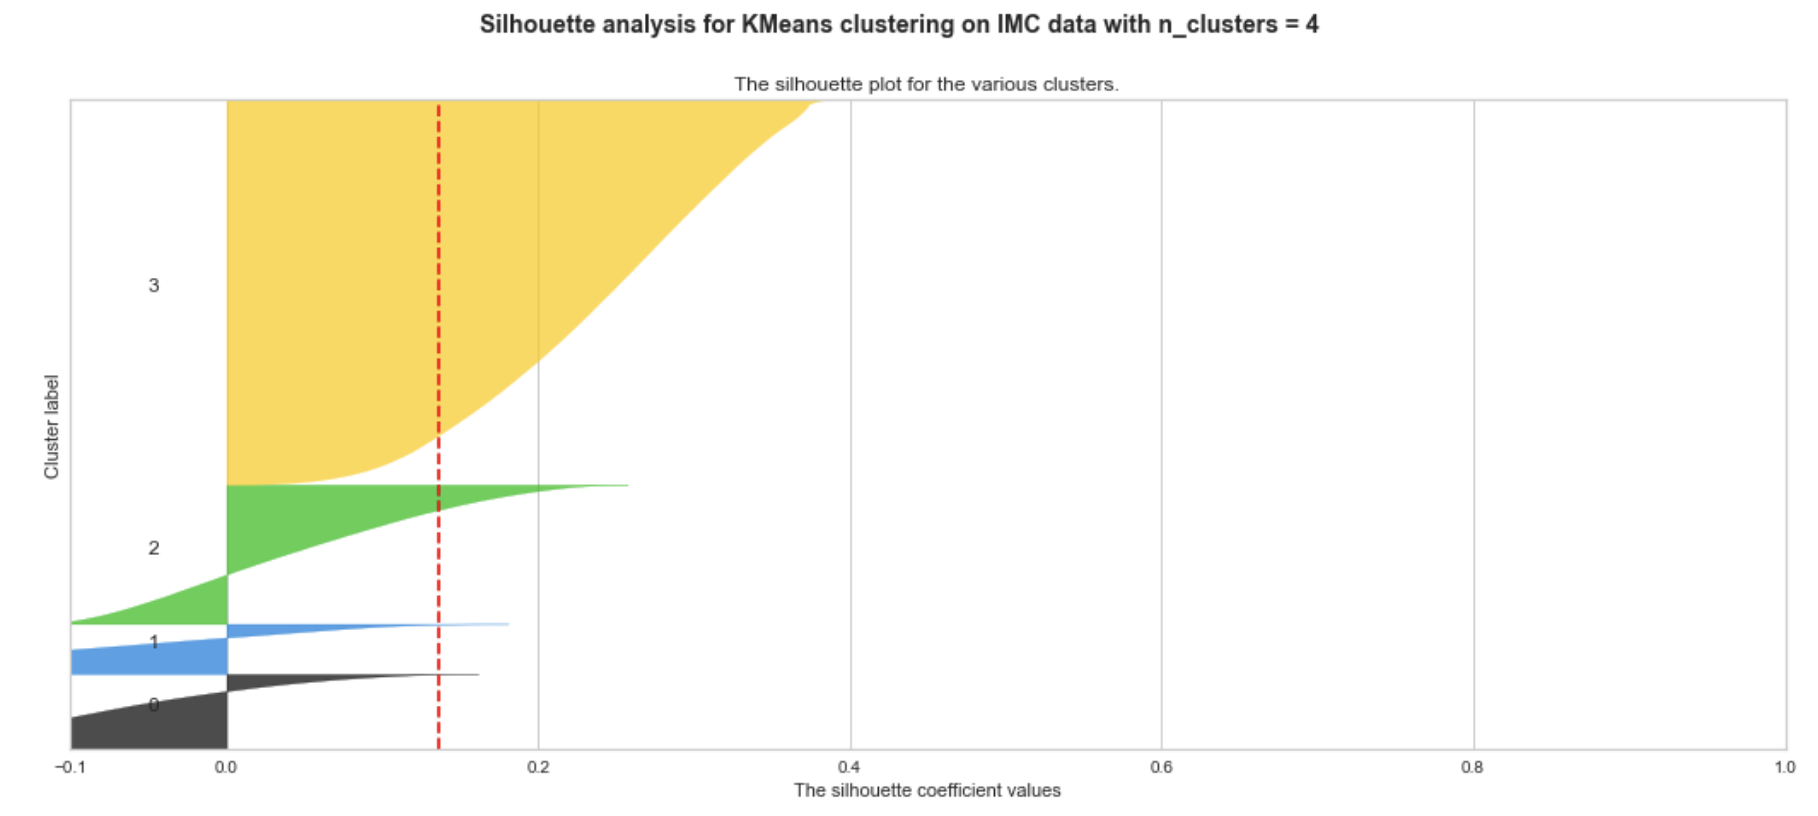

In [68]:
from IPython.display import Image
Image(filename='./assets/silhouette_4.png', width=600)

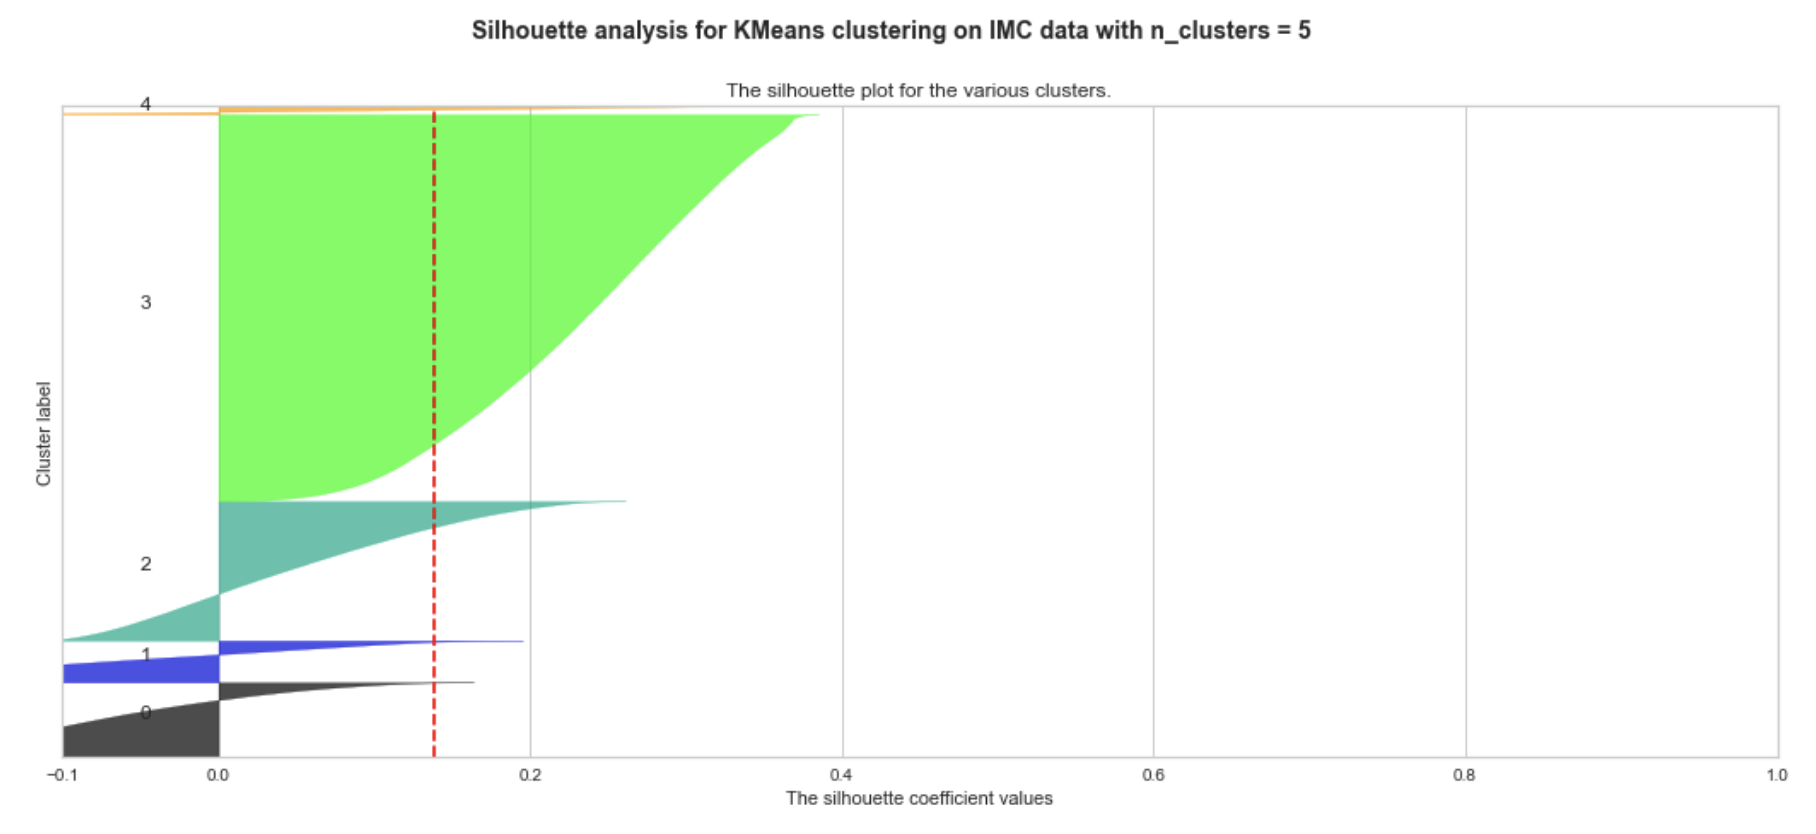

In [69]:
from IPython.display import Image
Image(filename='./assets/silhouette_5.png', width=600)

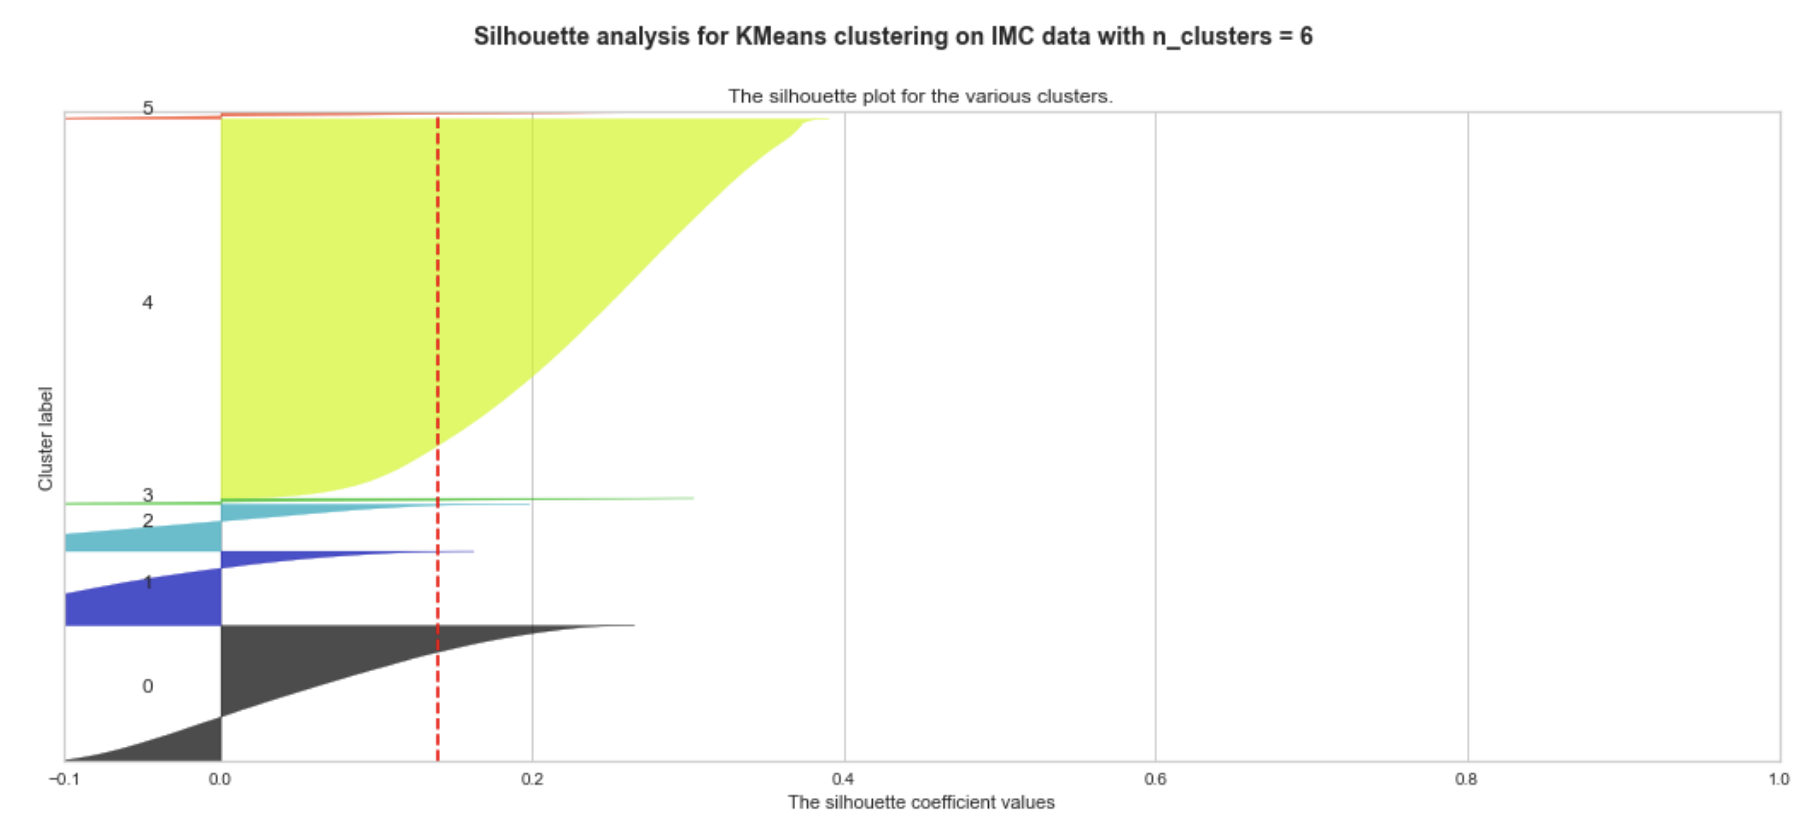

In [70]:
from IPython.display import Image
Image(filename='./assets/silhouette_6.png', width=600)

### K-means segmentation showing selected feature channels

In [71]:
K = 7  # Number of clusters (3 is elbow point, 2 is silhouette, 7 is "nice")
max_iter = 300 # Max number of iteration
tol = 0.0001 # Tolerance
kmeans_model = KMeans(n_clusters=K, random_state=42, max_iter=max_iter, tol=tol)
print(kmeans_model)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=7, n_init=10, n_jobs='deprecated',
       precompute_distances='deprecated', random_state=42, tol=0.0001,
       verbose=0)


In [72]:
%%time
kmeans_fit = kmeans_model.fit(X_scaled)

CPU times: user 1min 34s, sys: 3.34 s, total: 1min 37s
Wall time: 6.62 s


In [73]:
kmeans_segm = 0 * im_msk.copy()

In [74]:
for v in range(len(ind_roi[0])):
    kmeans_segm[ind_roi[0][v], ind_roi[1][v]] = kmeans_fit.labels_[v]

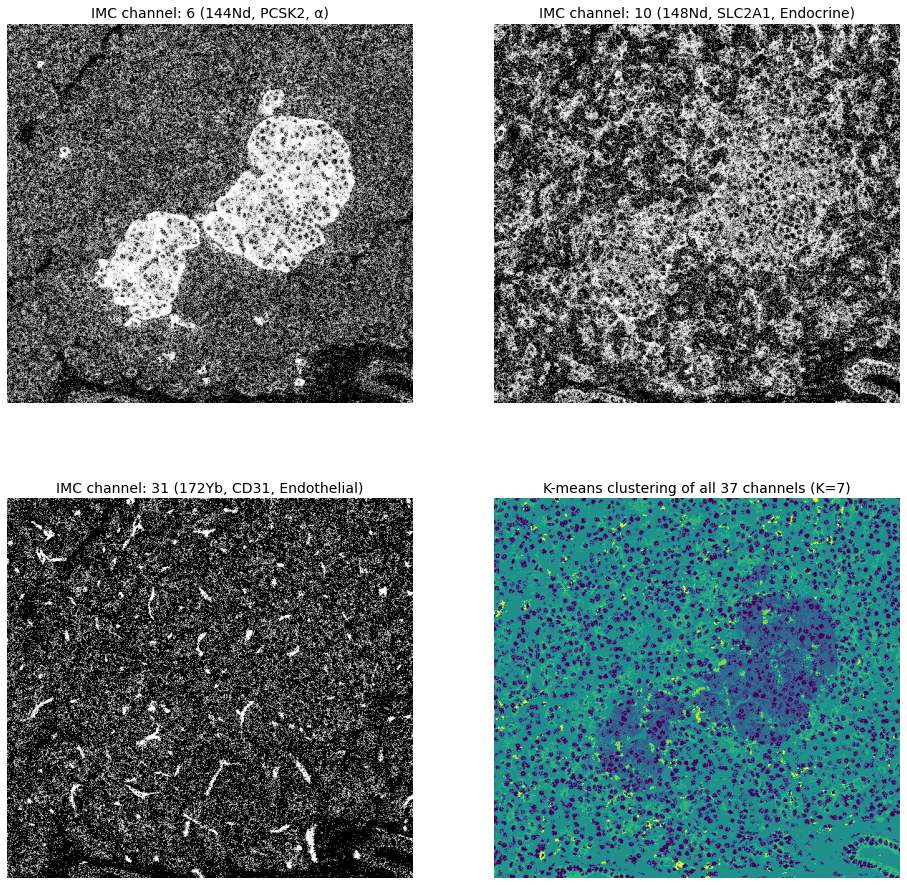

In [75]:
#df_p_sort_chn['Metal Tag']

fig_fn = '%s/BMED320_experiments_case6126_E08_selected_channels_and_k_means_clustering.pdf' % fn_fig_base

# Select channels (-1 i.e. we are starting at channel 0)
c = [5, 9, 30]

def hist_eq(chn):
    return np.sort(chn.ravel()).searchsorted(chn)


fig, axes = plt.subplots(2,2, figsize=(16,16))
ax = axes.ravel()
chn = np.flip(np.squeeze(im[c[0],:,:]), axis=0)
ax[0].imshow(hist_eq(chn), cmap='gray', origin='lower')
ax[0].set(xlabel="")
ax[0].axis('off')
ax[0].set_title('IMC channel: %d (%s, %s, %s)' % (c[0]+1,
                                                df_p_sort_chn['Metal Tag'].iloc[c[0]],
                                                df_p_sort_chn['Short Name'].iloc[c[0]],
                                                df_p_sort_chn['Main Target Cells'].iloc[c[0]]), size=14)

chn = np.flip(np.squeeze(im[c[1],:,:]), axis=0)
ax[1].imshow(hist_eq(chn), cmap='gray', origin='lower')
ax[1].set(xlabel="")
ax[1].axis('off')
ax[1].set_title('IMC channel: %d (%s, %s, %s)' % (c[1]+1,
                                                df_p_sort_chn['Metal Tag'].iloc[c[1]],
                                                df_p_sort_chn['Short Name'].iloc[c[1]],
                                                df_p_sort_chn['Main Target Cells'].iloc[c[1]]), size=14)

chn = np.flip(np.squeeze(im[c[2],:,:]), axis=0)
ax[2].imshow(hist_eq(chn), cmap='gray', origin='lower')
ax[2].set(xlabel="")
ax[2].axis('off')
ax[2].set_title('IMC channel: %d (%s, %s, %s)' % (c[2]+1, 
                                        df_p_sort_chn['Metal Tag'].iloc[c[2]],
                                        df_p_sort_chn['Short Name'].iloc[c[2]],
                                        df_p_sort_chn['Main Target Cells'].iloc[c[2]]), size=14)                                          

ax[3].imshow(np.flip(kmeans_segm[:, :], axis=0), cmap='viridis', origin='lower')  #'viridis', 'gray'
ax[3].set_title('K-means clustering of all %d channels (K=%d)' % (n_chn, K), size=14)
ax[3].axis('off')

#plt.tight_layout
plt.savefig(fig_fn, bbox_inches='tight')
plt.show()

### K-means segmentation with varying K 

In [76]:
def k_means_explore(k, img, mask, kmeans_kwargs):
    kmeans_model = KMeans(n_clusters=k, **kmeans_kwargs)
    print(kmeans_model)   
    
    # Find voxel locations (ind_roi) corresponding to tissue ROI (value >=1 inside ROI, 0 else) 
    ind_roi = np.where(mask > 0) 
    X = np.transpose(np.asarray(im[:,ind_roi[0],ind_roi[1]])) # The pixel channel signatures within the ROI
    
    scaler = StandardScaler()  
    scaler.fit(X.astype(float))
    scaled_features = scaler.transform(X.astype(float))  

    
    kmeans_fit = kmeans_model.fit(scaled_features)
    kmeans_segm = 0 * mask.copy()
    for v in range(len(ind_roi[0])):
        kmeans_segm[ind_roi[0][v], ind_roi[1][v]] = kmeans_fit.labels_[v]
        
    return kmeans_segm

K= 2
KMeans(algorithm='auto', copy_x=True, init='random', max_iter=300, n_clusters=2,
       n_init=10, n_jobs='deprecated', precompute_distances='deprecated',
       random_state=42, tol=0.0001, verbose=0)
K= 3
KMeans(algorithm='auto', copy_x=True, init='random', max_iter=300, n_clusters=3,
       n_init=10, n_jobs='deprecated', precompute_distances='deprecated',
       random_state=42, tol=0.0001, verbose=0)
K= 4
KMeans(algorithm='auto', copy_x=True, init='random', max_iter=300, n_clusters=4,
       n_init=10, n_jobs='deprecated', precompute_distances='deprecated',
       random_state=42, tol=0.0001, verbose=0)
K= 5
KMeans(algorithm='auto', copy_x=True, init='random', max_iter=300, n_clusters=5,
       n_init=10, n_jobs='deprecated', precompute_distances='deprecated',
       random_state=42, tol=0.0001, verbose=0)
K= 6
KMeans(algorithm='auto', copy_x=True, init='random', max_iter=300, n_clusters=6,
       n_init=10, n_jobs='deprecated', precompute_distances='deprecated',
       rando

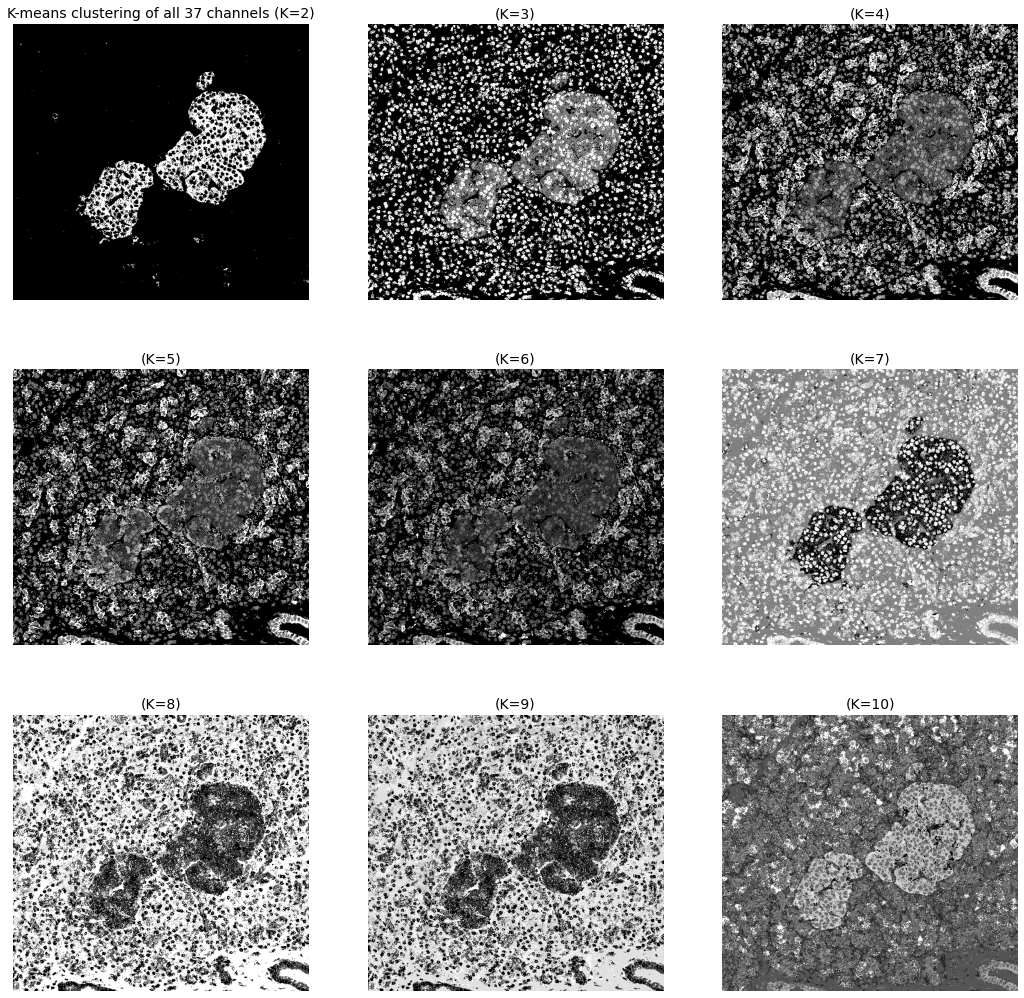

CPU times: user 12min 23s, sys: 16.2 s, total: 12min 39s
Wall time: 54 s


In [77]:
%%time

fig_fn = '%s/BMED320_experiments_case6126_E08_k_means_clustering_k_2_10.pdf' % fn_fig_base

kmeans_kwargs = {
    "init": "random",
    "n_init": 10,
    "max_iter": 300,
    "tol": 0.0001,
    "random_state": 42,
}

cmap = 'gray'  # 'viridis'
my_img = im
my_mask = im[0,:,:]+1
my_n_chn = my_img.shape[0]

fig, axes = plt.subplots(3, 3, figsize=(18, 18), sharex=False, sharey=False)
ax = axes.ravel()

for k in range(0, 9):
    K=k+2
    print('K=', K)
    kmeans_segm = k_means_explore(K, my_img, my_mask, kmeans_kwargs)

    ax[k].imshow(np.flip(kmeans_segm[:, :], axis=0), cmap=cmap, origin='lower')  #'viridis', 'gray'
    if k==0:
        ax[k].set_title('K-means clustering of all %d channels (K=%d)' % (my_n_chn, K), size=14)
    else:
        ax[k].set_title('(K=%d)' % (K), size=14)    
    ax[k].axis('off')
    
plt.savefig(fig_fn, bbox_inches='tight')
plt.show()

## Display DNA only (cell nuclei)  i.e. chn 36 (Ir191) and chn 37 (Ir193)
Hint from Jørn Skavland (Jorn.Skavland@uib.no) Oct 1st 2020 at https://www.uib.no/en/ccbio/136800/hyperion-imaging-system

# K-means clustering using scikit-learn

### Cell segmentation using the 3 nucleus channels: Histone H3 nuclei (chn1) and DNA (chn36, chn 37)

In [78]:
# Select channels (-1 i.e. we are starting at channel 0)
c = [0, 35, 36]

In [79]:
# Generally, we could use a restricted ROI mask for the cells in the slide. 
# Since cells are all over the slide, we let this ROI be the whole first channel in the slide stack + 1, i.e.
im_msk = im[0,:,:]+1
print(im_msk.flatten().min())
print(im_msk.flatten().max())
im_msk.shape

1.0
378.168


(530, 567)

In [80]:
# Find voxel locations (ind_roi) corresponding to tissue ROI (value >=1 inside ROI, 0 else) 
ind_roi = np.where(im_msk > 0) 

#### Make it into RGB space

In [82]:
r = np.squeeze(im[c[0],:,:]); r = hist_eq(r); r = np.uint8(255.0 * r/np.max(r))
g = np.squeeze(im[c[1],:,:]); g = hist_eq(g); g = np.uint8(255.0 * g/np.max(g))
b = np.squeeze(im[c[2],:,:]); b = hist_eq(b); b = np.uint8(255.0 * b/np.max(b))

dims = list(np.squeeze(im[0,:,:]).shape)
dims.append(3)
dna_rgb = np.zeros(shape=dims, dtype=np.uint8)
dna_rgb[:,:,0] = r; dna_rgb[:,:,1] = g; dna_rgb[:,:,2] = b

print(dna_rgb.shape)
print(type(dna_rgb))
print(dna_rgb.dtype)
#mx = np.max(color.rgb2gray(dna_rgb))

tiff.imsave('%s/tmp/dna_rgb.tiff' % (home), dna_rgb)
#tiff.imsave('%s/tmp/dna_rgb2gray.tiff' % (home), np.uint8(255*color.rgb2gray(dna_rgb)/mx))

(530, 567, 3)
<class 'numpy.ndarray'>
uint8


In [83]:
dims = np.prod(np.squeeze(im[0,:,:]).shape)
dataset = np.zeros(shape=[dims, 3]) # , dtype=np.uint8)
dataset[:,0] = r.flatten()
dataset[:,1] = g.flatten()
dataset[:,2] = b.flatten()
dataset.shape

(300510, 3)

In [84]:
chn01 = df_p_sort_chn['Metal Tag'].iloc[c[0]]
chn36 = df_p_sort_chn['Metal Tag'].iloc[c[1]]
chn37 = df_p_sort_chn['Metal Tag'].iloc[c[2]]
data = pd.DataFrame(data=dataset, columns=[chn01, chn36, chn37])
data

113In  191Ir  193Ir
0        42.0   97.0    0.0
1       191.0  132.0  168.0
2       221.0  253.0  245.0
3       210.0  249.0  251.0
4       226.0  241.0  251.0
...       ...    ...    ...
300505  205.0  229.0  237.0
300506  245.0  247.0  252.0
300507  244.0  240.0  241.0
300508  234.0  216.0  209.0
300509  216.0  182.0  192.0

[300510 rows x 3 columns]

In [85]:
scaler = StandardScaler()  
scaler.fit(data.astype(float))

dna_names = df_p_sort_chn['Metal Tag'].iloc[c]
X = data
X_scaled = scaler.transform(X.astype(float))  

# Make data frame from scaled X to check scaling
dX_scaled = pd.DataFrame(X_scaled, columns=dna_names)
dX_scaled.head().T

0         1         2         3         4
Metal Tag                                                  
113In     -1.091671  0.864903  1.258844  1.114399  1.324501
191Ir     -0.327223  0.115113  1.644330  1.593777  1.492672
193Ir     -1.672050  0.559668  1.582538  1.662243  1.662243

In [86]:
dX_scaled.describe(percentiles = [0.5]).round(4).T

count  mean  std     min     50%     max
Metal Tag                                             
113In      300510.0  -0.0  1.0 -1.6432  0.0245  1.7053
191Ir      300510.0   0.0  1.0 -1.5531  0.0519  1.6696
193Ir      300510.0  -0.0  1.0 -1.6721  0.0150  1.7154

In [87]:
K = 4  # Number of clusters (cell / no-cell / intermediate)
max_iter = 300 # Max number of iteration
tol = 0.0001 # Tolerance
kmeans_model = KMeans(n_clusters=K, random_state=42, max_iter=max_iter, tol=tol)
print(kmeans_model)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=4, n_init=10, n_jobs='deprecated',
       precompute_distances='deprecated', random_state=42, tol=0.0001,
       verbose=0)


In [88]:
%%time
kmeans_fit = kmeans_model.fit(X_scaled)

CPU times: user 28 s, sys: 975 ms, total: 29 s
Wall time: 1.97 s


In [89]:
kmeans_segm = 0 * im_msk.copy()
print('Size of segmented image:', kmeans_segm.shape)
print('min:', kmeans_fit.labels_.min())
print('max:', kmeans_fit.labels_.max())
print('Number of clustered samples within ROI:', len(ind_roi[0]))

Size of segmented image: (530, 567)
min: 0
max: 3
Number of clustered samples within ROI: 300510


In [90]:
kmeans_segm = np.ravel(np.ones(dims)*kmeans_fit.labels_).reshape(np.squeeze(im[0,:,:]).shape)
kmeans_segm = np.uint8(kmeans_segm)
print(kmeans_segm.shape)
print(np.int8(kmeans_segm.min()), np.int8(kmeans_segm.max()))
unique, counts = np.unique(kmeans_segm, return_counts=True)
dict(zip(np.int8(unique), counts))

(530, 567)
0 3


{0: 78911, 1: 82403, 2: 69026, 3: 70170}

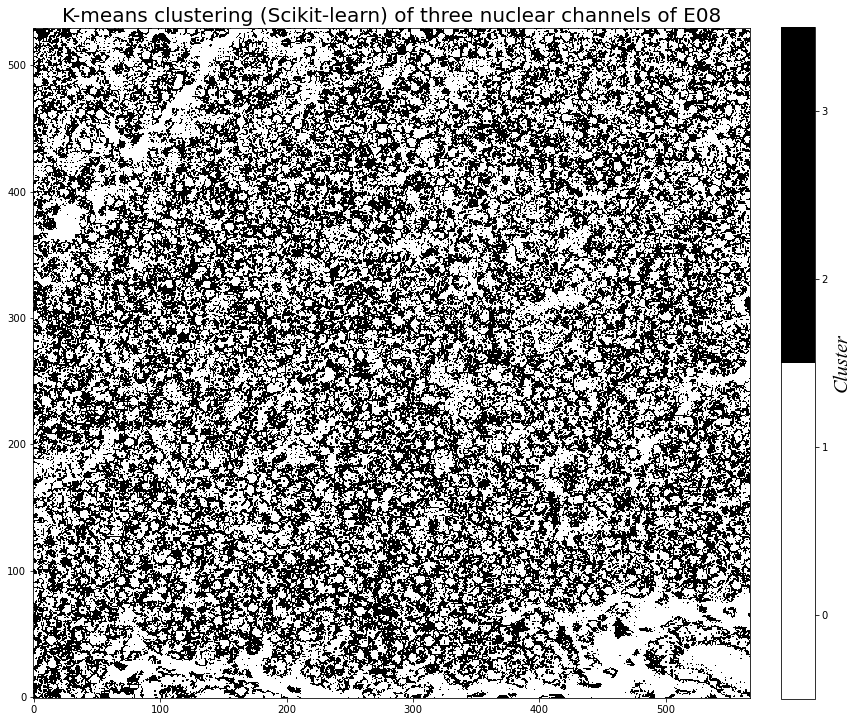

In [91]:
fig, axes = plt.subplots(1,1, figsize=(14,14))
# Possible colormaps: 'gray', 'jet', 'cubehelix', 
my_cmap = mpl.colors.ListedColormap(['#ffffff', '#ffffff','#000000', '#000000']) # 'blue'])
#plt.imshow(np.flip(kmeans_segm[:, :], axis=0), cmap=discrete_cmap(K, 'gray'), origin='lower') 
plt.imshow(np.flip(kmeans_segm[:, :], axis=0), cmap=my_cmap, origin='lower') 

# See: https://stackoverflow.com/questions/18195758/set-matplotlib-colorbar-size-to-match-graph
im_ratio = kmeans_segm.shape[0]/kmeans_segm.shape[1]
cb = plt.colorbar(label='Cluster', orientation='vertical', fraction=0.046*im_ratio, pad=0.04)
ax = cb.ax
text = ax.yaxis.label
font = mpl.font_manager.FontProperties(family='times new roman', style='italic', size=20)
text.set_font_properties(font)


plt.clim(-0.5, K - 0.5)
labels = np.arange(0,K,1)
cb.set_ticks(labels)
cb.set_ticklabels(labels)



plt.title('K-means clustering (Scikit-learn) of three nuclear channels of E08', size=20)
plt.show()

In [92]:
tiff.imsave('%s/tmp/kmeans_segm.tiff' % (home), kmeans_segm)

Check: https://github.com/computational-medicine/BMED360-2020/blob/master/perfusion/01-perf-explore.ipynb for more